<a href="https://colab.research.google.com/github/envirodatascience/final-project-agrivoltaics/blob/main/617_Agrivoltaics_UK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UK Agrivoltaics
Aim: find and model variables to help indicate regions in the UK that could be proposed to the UK government as suiatble sites for a concentrated agrivoltaics pilot program.

#Question 1: Where are the existing ground-mounted solar farms?

To understand where it is most viable to propose a government-driven geographic focus on agrivoltaics programs, it is useful to understand where solar farms currently exist in the UK. If we see an area with a higher number of solar farms, there are likely factors in that area that make it commercially viable to operate a slaor energy operation in the area. Conversely, areas lacking solar farms indicate that there may be factors in the area inhibiting solar farm operations.

Goal: plot existing solar farms in the UK over a base map of the UK, separated by county level.

Note: The UK does not have data on solar farms that are specifically agrivoltaics. Commercial ground-standing solar farm data have been used as a proxy.

# 1a) Import packages

In [1]:
# basics
import pandas as pd
import numpy as np

# geo
import geopandas as gpd
from shapely.geometry import Point
import pyproj
from geopandas.tools import sjoin

# plotting
from plotnine import *
import plotnine
import matplotlib.pyplot as plt

# astral
!pip install astral
!pip install matplotlib numpy
!pip install cartopy
from astral import LocationInfo
from astral.sun import sun
from astral import LocationInfo
from datetime import date, timedelta
import cartopy.crs as ccrs
import cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 52.6 MB/s eta 0:00:00


# 1b) Upload dataframe of location of current and planned UK ground mounted solar farms.

Steps:

1) Import renewable energy csv into python

2) Filter for Technology Type = Solar Photovoltaics, Development Status = Operational

3) Get shapefile data for UK by county/region and then use the coordinate data in the solar df to create a map of the regions with the most operational ground mounted solar frames

In [3]:
csv_file_path = 'https://raw.githubusercontent.com/envirodatascience/final-project-agrivoltaics/main/TRUE_UK_renewable_energy_location.csv'

# Read the CSV file into a DataFrame
df_UK_solar_og = pd.read_csv(csv_file_path)

# Check columns
df_UK_solar_og.columns



Index(['Old Ref ID', 'Ref ID', 'Record Last Updated (dd/mm/yyyy)',
       'Operator (or Applicant)', 'Site Name', 'Technology Type',
       'Storage Type', 'Storage Co-location REPD Ref ID',
       'Installed Capacity (MWelec)', 'Share Community Scheme', 'CHP Enabled',
       'CfD Allocation Round', 'RO Banding (ROC/MWh)', 'FiT Tariff (p/kWh)',
       'CfD Capacity (MW)', 'Turbine Capacity (MW)', 'No. of Turbines',
       'Height of Turbines (m)', 'Mounting Type for Solar',
       'Development Status', 'Development Status (short)',
       'Are they re-applying (New REPD Ref)',
       'Are they re-applying (Old REPD Ref)', 'Address', 'County', 'Region',
       'Country', 'Post Code', 'X-coordinate', 'Y-coordinate',
       'Planning Authority', 'Planning Application Reference',
       'Appeal Reference', 'Secretary of State Reference',
       'Type of Secretary of State Intervention', 'Judicial Review',
       'Offshore Wind Round', 'Planning Application Submitted',
       'Planning Appl

In [4]:
# Strip whitespace from column names
#df_UK_solar_og.columns = df_UK_solar_og.columns.str.strip()

df_UK_solar_og['Technology Type']

# Filter rows where 'Technology Type' is 'Solar Photovoltaics'
df_UK_solar = df_UK_solar_og[df_UK_solar_og['Technology Type'] == 'Solar Photovoltaics']

In [5]:
#preview filtered data
df_UK_solar.head()

Old Ref ID  Ref ID Record Last Updated (dd/mm/yyyy)  \
909      A0429    1018                       21/07/2011   
910      A0503    1019                       01/09/2011   
911      A0504    1020                       01/09/2011   
912      A0506    1021                       08/07/2011   
913      A0507    1022                       01/09/2011   

       Operator (or Applicant)            Site Name      Technology Type  \
909                 Ecotricity  Fen Farm Solar Park  Solar Photovoltaics   
910  Low carbon Solar Partners           Manor Farm  Solar Photovoltaics   
911  Low carbon Solar Partners       Nanterrow Farm  Solar Photovoltaics   
912  Low carbon Solar Partners          Howton Farm  Solar Photovoltaics   
913  Low carbon Solar Partners   East Langford Farm  Solar Photovoltaics   

    Storage Type Storage Co-location REPD Ref ID  Installed Capacity (MWelec)  \
909          NaN                             NaN                          1.0   
910          NaN                             NaN                          4.7   
911          NaN                             NaN                          4.7   
912          NaN                             NaN                          4.4   
913          NaN                             NaN                          5.0   

    Share Community Scheme  ... Appeal Refused Appeal Granted  \
909                    NaN  ...            NaN            NaN   
910                    NaN  ...            NaN            NaN   
911                    NaN  ...            NaN            NaN   
912                    NaN  ...            NaN            NaN   
913                    NaN  ...            NaN            NaN   

     Planning Permission  Granted  Secretary of State - Intervened  \
909                    12/11/2010                              NaN   
910                    14/04/2011                              NaN   
911                    14/04/2011                              NaN   
912                    18/04/2011                              NaN   
913                    18/04/2011                              NaN   

     Secretary of State - Refusal  Secretary of State - Granted  \
909                           NaN                           NaN   
910                           NaN                           NaN   
911                           NaN                           NaN   
912                           NaN                           NaN   
913                           NaN                           NaN   

     Planning Permission Expired  Under Construction Operational  \
909                          NaN                 NaN  11/07/2011   
910                          NaN                 NaN  25/07/2011   
911                          NaN                 NaN  25/07/2011   
912                          NaN                 NaN  22/07/2011   
913                          NaN                 NaN  25/07/2011   

    Heat Network Ref  
909              NaN  
910              NaN  
911              NaN  
912              NaN  
913              NaN  

[5 rows x 52 columns]

In [6]:
# Filter for Development Status = Operational
df_UK_solar = df_UK_solar_og[df_UK_solar_og['Development Status'] == 'Operational']
df_UK_solar.head()

Old Ref ID  Ref ID Record Last Updated (dd/mm/yyyy)  \
0     N00053B       1                       07/07/2009   
2       B0730       3                       20/12/2019   
3     1106000       4                       18/12/2003   
13      A0331      14                       04/04/2012   
16      AA851      22                       10/08/2012   

               Operator (or Applicant)                         Site Name  \
0                           RWE npower    Aberthaw Power Station Biomass   
2   Scottish and Southern Energy (SSE)     Ferrybridge Multifuel 2 (FM2)   
3               Energy Power Resources    Thetford Biomass Power Station   
13                              Dalkia              Chilton Energy Plant   
16                  Double H Nurseries  Double H Nurseries Biomass Plant   

        Technology Type Storage Type Storage Co-location REPD Ref ID  \
0   Biomass (co-firing)          NaN                             NaN   
2      EfW Incineration          NaN                             NaN   
3   Biomass (dedicated)          NaN                             NaN   
13  Biomass (dedicated)          NaN                             NaN   
16  Biomass (dedicated)          NaN                             NaN   

    Installed Capacity (MWelec) Share Community Scheme  ... Appeal Refused  \
0                          35.0                    NaN  ...            NaN   
2                          70.0                    NaN  ...            NaN   
3                          38.5                    NaN  ...            NaN   
13                         18.0                    NaN  ...            NaN   
16                          1.5                    NaN  ...            NaN   

   Appeal Granted  Planning Permission  Granted  \
0             NaN                    03/09/2004   
2             NaN                    28/10/2015   
3             NaN                    05/05/1995   
13            NaN                    24/11/2009   
16            NaN                    29/05/2012   

    Secretary of State - Intervened  Secretary of State - Refusal  \
0                               NaN                           NaN   
2                               NaN                           NaN   
3                               NaN                           NaN   
13                              NaN                           NaN   
16                              NaN                           NaN   

    Secretary of State - Granted  Planning Permission Expired  \
0                            NaN                          NaN   
2                            NaN                   28/10/2020   
3                            NaN                          NaN   
13                           NaN                          NaN   
16                           NaN                          NaN   

    Under Construction Operational Heat Network Ref  
0           01/05/2006  01/05/2007              NaN  
2           01/09/2016  20/12/2019              NaN  
3                  NaN  02/10/1998              NaN  
13          01/03/2010  12/03/2012              NaN  
16                 NaN  15/12/2012              NaN  

[5 rows x 52 columns]

In [7]:
#Drop unneeded columns
df_UK_solar = df_UK_solar.drop(columns=['Old Ref ID','Ref ID','Storage Type','Storage Co-location REPD Ref ID','Share Community Scheme','CfD Allocation Round','RO Banding (ROC/MWh)','FiT Tariff (p/kWh)','CfD Capacity (MW)','Turbine Capacity (MW)','No. of Turbines','Height of Turbines (m)','Mounting Type for Solar','Are they re-applying (New REPD Ref)','Are they re-applying (Old REPD Ref)','Secretary of State Reference','Type of Secretary of State Intervention','Judicial Review','Offshore Wind Round','Planning Application Submitted','Planning Application Withdrawn','Planning Permission Refused','Appeal Lodged','Appeal Withdrawn','Appeal Refused','Appeal Granted','Planning Permission  Granted','Secretary of State - Intervened','Secretary of State - Refusal','Secretary of State - Granted','Planning Permission Expired','Heat Network Ref'])

In [8]:
# Check df
df_UK_solar.head()

Record Last Updated (dd/mm/yyyy)             Operator (or Applicant)  \
0                        07/07/2009                          RWE npower   
2                        20/12/2019  Scottish and Southern Energy (SSE)   
3                        18/12/2003              Energy Power Resources   
13                       04/04/2012                              Dalkia   
16                       10/08/2012                  Double H Nurseries   

                           Site Name      Technology Type  \
0     Aberthaw Power Station Biomass  Biomass (co-firing)   
2      Ferrybridge Multifuel 2 (FM2)     EfW Incineration   
3     Thetford Biomass Power Station  Biomass (dedicated)   
13              Chilton Energy Plant  Biomass (dedicated)   
16  Double H Nurseries Biomass Plant  Biomass (dedicated)   

    Installed Capacity (MWelec) CHP Enabled Development Status  \
0                          35.0          No        Operational   
2                          70.0          No        Operational   
3                          38.5          No        Operational   
13                         18.0          No        Operational   
16                          1.5         Yes        Operational   

   Development Status (short)  \
0                 Operational   
2                 Operational   
3                 Operational   
13                Operational   
16                Operational   

                                              Address           County  \
0    Aberthaw Power Station, The Leys, Aberthaw Barry  South Glamorgan   
2                                                 NaN   West Yorkshire   
3   Thetford Power Station\n, Marley Building Mate...          Norfolk   
13     Chilton Industrial Estate, Chilton, Ferryhill,    County Durham   
16         Double H Nurseries, Gore Road, New Milton         Hampshire   

                  Region  Country Post Code  X-coordinate  Y-coordinate  \
0                  Wales    Wales  CF62 4ZW      302219.0      166320.0   
2   Yorkshire and Humber  England       NaN      447490.0      424684.0   
3                Eastern  England       NaN      585300.0      286900.0   
13            North East  England       NaN      428049.0      530414.0   
16            South East  England  BH25 5NQ      422804.0       94625.0   

                                   Planning Authority  \
0                           Vale of Glamorgan Council   
2   The Planning Inspectorate - National Infrastru...   
3                                   Breckland Council   
13                              Durham County Council   
16                           Hampshire County Council   

   Planning Application Reference Appeal Reference Under Construction  \
0                    04/00580/FUL              NaN         01/05/2006   
2                        EN010061              NaN         01/09/2016   
3                             NaN              NaN                NaN   
13                 7/2008/0522/DM              NaN         01/03/2010   
16                       12/98264              NaN                NaN   

   Operational  
0   01/05/2007  
2   20/12/2019  
3   02/10/1998  
13  12/03/2012  
16  15/12/2012

# 1c) Extract coordinates from dataframe

Filter new dataframe df_UK_solar_XY, then convert to gdf perform latitude/longitude transformation.

In [9]:
df_UK_solar_XY = df_UK_solar[['X-coordinate', 'Y-coordinate']].copy()
df_UK_solar_XY

X-coordinate  Y-coordinate
0         302219.0      166320.0
2         447490.0      424684.0
3         585300.0      286900.0
13        428049.0      530414.0
16        422804.0       94625.0
...            ...           ...
9789      431334.0      431974.0
9828      519788.0      196844.0
9849      337383.0      348803.0
9963      453576.0      332916.0
9967      179412.0       20706.0

[2952 rows x 2 columns]

In [10]:
#Convert to gdf

# Create a geometry column with Point objects
geometry = [Point(xy) for xy in zip(df_UK_solar_XY['X-coordinate'], df_UK_solar_XY['Y-coordinate'])]

# Create a GeoDataFrame
gdf_UK_solar_XY = gpd.GeoDataFrame(df_UK_solar_XY, geometry=geometry)

# Display the GeoDataFrame
gdf_UK_solar_XY.head()

/usr/local/lib/python3.10/dist-packages/geopandas/geoseries.py:751: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)


X-coordinate  Y-coordinate                       geometry
0       302219.0      166320.0  POINT (302219.000 166320.000)
2       447490.0      424684.0  POINT (447490.000 424684.000)
3       585300.0      286900.0  POINT (585300.000 286900.000)
13      428049.0      530414.0  POINT (428049.000 530414.000)
16      422804.0       94625.0   POINT (422804.000 94625.000)

In [11]:
# transform X and Y coordinates to latitude and longitude points

# Define the coordinate reference systems
crs_bng = pyproj.CRS("EPSG:27700")  # British National Grid
crs_wgs84 = pyproj.CRS("EPSG:4326")  # WGS84

# Create a transformer to convert from BNG to WGS84
transformer = pyproj.Transformer.from_crs(crs_bng, crs_wgs84, always_xy=True)

# Apply the transformer to each row to convert X-coordinate and Y-coordinate to longitude and latitude
gdf_UK_solar_coordinates = gdf_UK_solar_XY[['X-coordinate', 'Y-coordinate']].copy()
gdf_UK_solar_coordinates['longitude'], gdf_UK_solar_coordinates['latitude'] = transformer.transform(gdf_UK_solar_coordinates['X-coordinate'].values, gdf_UK_solar_coordinates['Y-coordinate'].values)

# Display the updated DataFrame
gdf_UK_solar_coordinates.head()

X-coordinate  Y-coordinate  longitude   latitude
0       302219.0      166320.0  -3.406610  51.387471
2       447490.0      424684.0  -1.281885  53.716417
3       585300.0      286900.0   0.725273  52.448628
13      428049.0      530414.0  -1.566632  54.668027
16      422804.0       94625.0  -1.678119  50.750782

In [12]:
#Filter data for Constantine to use in his Colab notebook for question 2 (since re-imported into this notebook)
df_UK_solar_filtered = df_UK_solar[['Site Name', 'X-coordinate', 'Y-coordinate']]
df_UK_solar_filtered

Site Name  X-coordinate  \
0                        Aberthaw Power Station Biomass      302219.0   
2                         Ferrybridge Multifuel 2 (FM2)      447490.0   
3                        Thetford Biomass Power Station      585300.0   
13                                 Chilton Energy Plant      428049.0   
16                     Double H Nurseries Biomass Plant      422804.0   
...                                                 ...           ...   
9789                        LVF Packaging - Solar Panel      431334.0   
9828  Elstree Film And TV Studios, Shenley Road - So...      519788.0   
9849                      F Lloyd Penley - Solar Panels      337383.0   
9963  Fairham Business Park, Foresters Avenue  - Roo...      453576.0   
9967                            Roskilly's - Solar Farm      179412.0   

      Y-coordinate  
0         166320.0  
2         424684.0  
3         286900.0  
13        530414.0  
16         94625.0  
...            ...  
9789      431974.0  
9828      196844.0  
9849      348803.0  
9963      332916.0  
9967       20706.0  

[2952 rows x 3 columns]

In [13]:
# Export DataFrame to CSV
df_UK_solar_filtered.to_csv('df_UK_solar_filtered.csv', index=False)

# Download the CSV file
from google.colab import files
files.download('df_UK_solar_filtered.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 1d) Read in UK base map divided by counties
Note: Initial attempts to read in this base map were unsuccessful due to file type.

In [14]:
# ! tells notebook to run a terminal command, rather than python code
# Colabl runs on Linux servers so unix commads will work (vs. Windows command line)
# 'wget' is terminal command to get content from website

! wget https://github.com/envirodatascience/final-project-agrivoltaics/raw/main/GBR_3.zip

--2024-04-29 01:34:50--  https://github.com/envirodatascience/final-project-agrivoltaics/raw/main/GBR_3.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/envirodatascience/final-project-agrivoltaics/main/GBR_3.zip [following]
--2024-04-29 01:34:50--  https://raw.githubusercontent.com/envirodatascience/final-project-agrivoltaics/main/GBR_3.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1700809 (1.6M) [application/zip]
Saving to: ‘GBR_3.zip’

GBR_3.zip           100%[===================>]   1.62M  --.-KB/s    in 0.06s   

2024-04-29 01:34:51 (26.9 MB/s) - ‘GBR_3.zip’ saved [1700809/1700809]

In [15]:
# 'ls' lists files in the current folder (also called a directory) on the server

! ls

df_UK_solar_filtered.csv  GBR_3.zip  sample_data


In [16]:
# 'unzip' unzips the file on the server

! unzip GBR_3.zip

Archive:  GBR_3.zip
  inflating: gadm36_GBR_3.cpg        
  inflating: __MACOSX/._gadm36_GBR_3.cpg  
  inflating: gadm36_GBR_3.dbf        
  inflating: __MACOSX/._gadm36_GBR_3.dbf  
  inflating: gadm36_GBR_3.prj        
  inflating: __MACOSX/._gadm36_GBR_3.prj  
  inflating: gadm36_GBR_3.shp        
  inflating: __MACOSX/._gadm36_GBR_3.shp  
  inflating: gadm36_GBR_3.shx        
  inflating: __MACOSX/._gadm36_GBR_3.shx  


In [17]:
! ls

df_UK_solar_filtered.csv  gadm36_GBR_3.dbf  gadm36_GBR_3.shp  GBR_3.zip  sample_data
gadm36_GBR_3.cpg	  gadm36_GBR_3.prj  gadm36_GBR_3.shx  __MACOSX


In [18]:
# read in the .shp file using the file path
shape = "gadm36_GBR_3.shp"
gdf_GBR_3 = gpd.read_file(shape)

<Axes: >

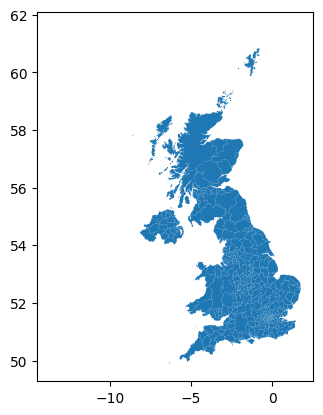

In [19]:
# Plot the GeoDataFrame
gdf_GBR_3.plot()

In [20]:
gdf_GBR_3.head()

GID_0          NAME_0    GID_1   NAME_1 NL_NAME_1      GID_2  \
0   GBR  United Kingdom  GBR.1_1  England      None  GBR.1.1_1   
1   GBR  United Kingdom  GBR.1_1  England      None  GBR.1.2_1   
2   GBR  United Kingdom  GBR.1_1  England      None  GBR.1.3_1   
3   GBR  United Kingdom  GBR.1_1  England      None  GBR.1.4_1   
4   GBR  United Kingdom  GBR.1_1  England      None  GBR.1.5_1   

                         NAME_2 NL_NAME_2        GID_3  \
0                      Barnsley      None  GBR.1.1.1_1   
1  Bath and North East Somerset      None  GBR.1.2.1_1   
2                  Bedfordshire      None  GBR.1.3.1_1   
3                    Birmingham      None  GBR.1.4.1_1   
4         Blackburn with Darwen      None  GBR.1.5.1_1   

                         NAME_3 VARNAME_3 NL_NAME_3  \
0                      Barnsley      None      None   
1  Bath and North East Somerset      None      None   
2                       Bedford      None      None   
3                    Birmingham      None      None   
4         Blackburn with Darwen      None      None   

                        TYPE_3                    ENGTYPE_3  CC_3    HASC_3  \
0         Metropolitan borough         Metropolitan borough  None  GB.BX.BX   
1            Unitary authority            Unitary authority  None  GB.BN.BN   
2            Unitary authority            Unitary authority  None  GB.FO.FO   
3  Metropolitan borough (city)  Metropolitan borough (city)  None  GB.BI.BI   
4            Unitary authority            Unitary authority  None  GB.BW.BW   

                                            geometry  
0  POLYGON ((-1.78997 53.47293, -1.79306 53.47778...  
1  POLYGON ((-2.68629 51.31516, -2.68066 51.32836...  
2  POLYGON ((-0.58508 52.11364, -0.58806 52.11805...  
3  POLYGON ((-1.73417 52.51014, -1.73984 52.50894...  
4  POLYGON ((-2.51111 53.63377, -2.51317 53.63582...

In [21]:
# Set the CRS to EPSG:4326 (WGS84)
gdf_GBR_3.crs = 'EPSG:4326'

In [22]:
#Convert solar farm df to gdf

# Create a geometry column with Point objects
geometry = [Point(xy) for xy in zip(df_UK_solar['X-coordinate'], df_UK_solar['Y-coordinate'])]

# Create a GeoDataFrame
gdf_UK_solar = gpd.GeoDataFrame(df_UK_solar, geometry=geometry)

In [23]:
# Set the CRS to EPSG:4326 (WGS84)
gdf_UK_solar.crs = 'EPSG:4326'

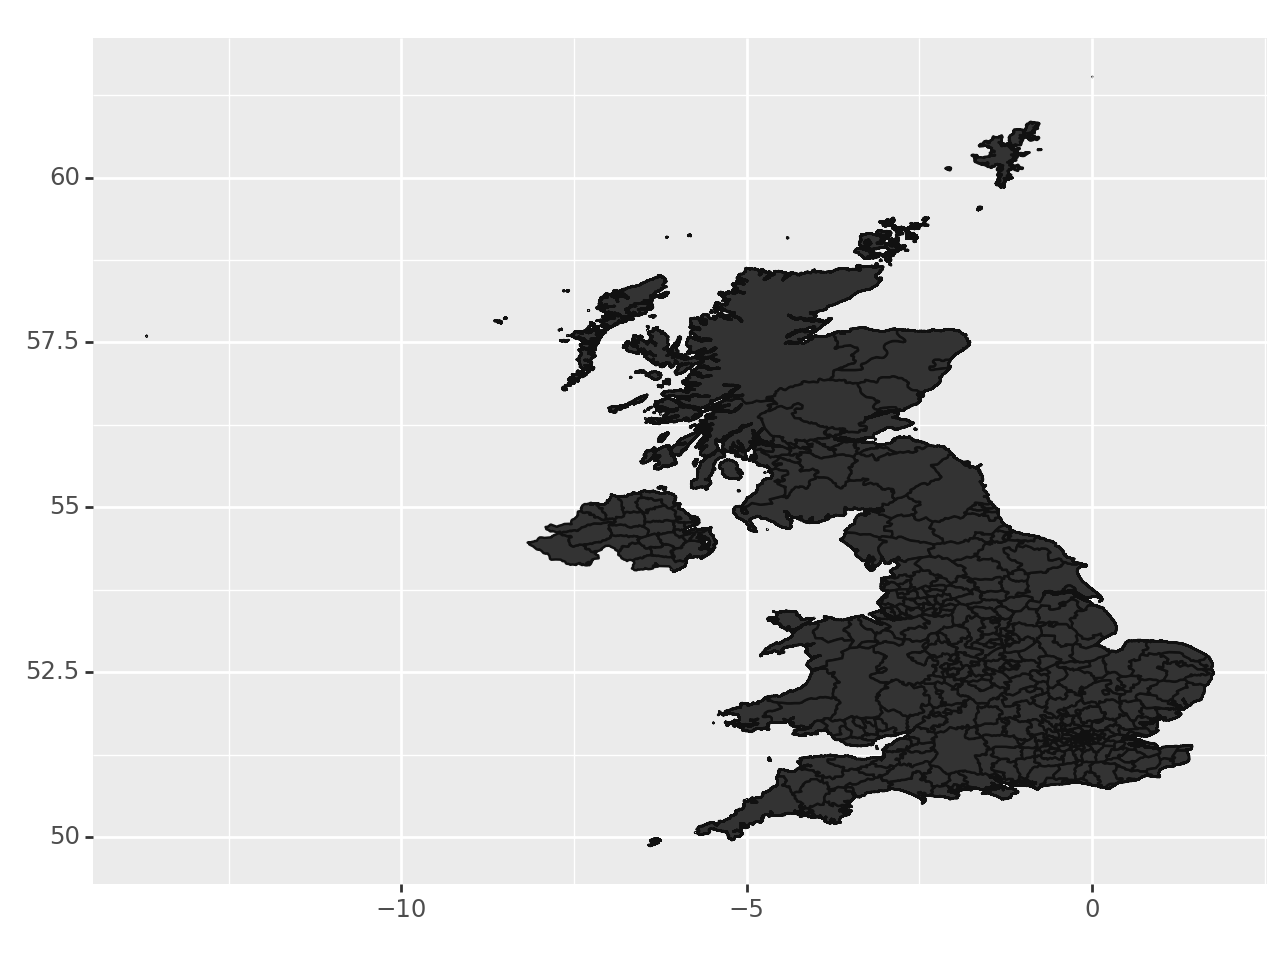

<Figure Size: (640 x 480)>

In [24]:
# Plot each GeoDataFrame

base = (
    ggplot()+
    geom_map(gdf_GBR_3)
)
base

In [25]:
# Set CRS system for gdf_UK_solar_XY to EPSG:4326 (WGS84)
gdf_UK_solar_XY.crs = 'EPSG:4326'


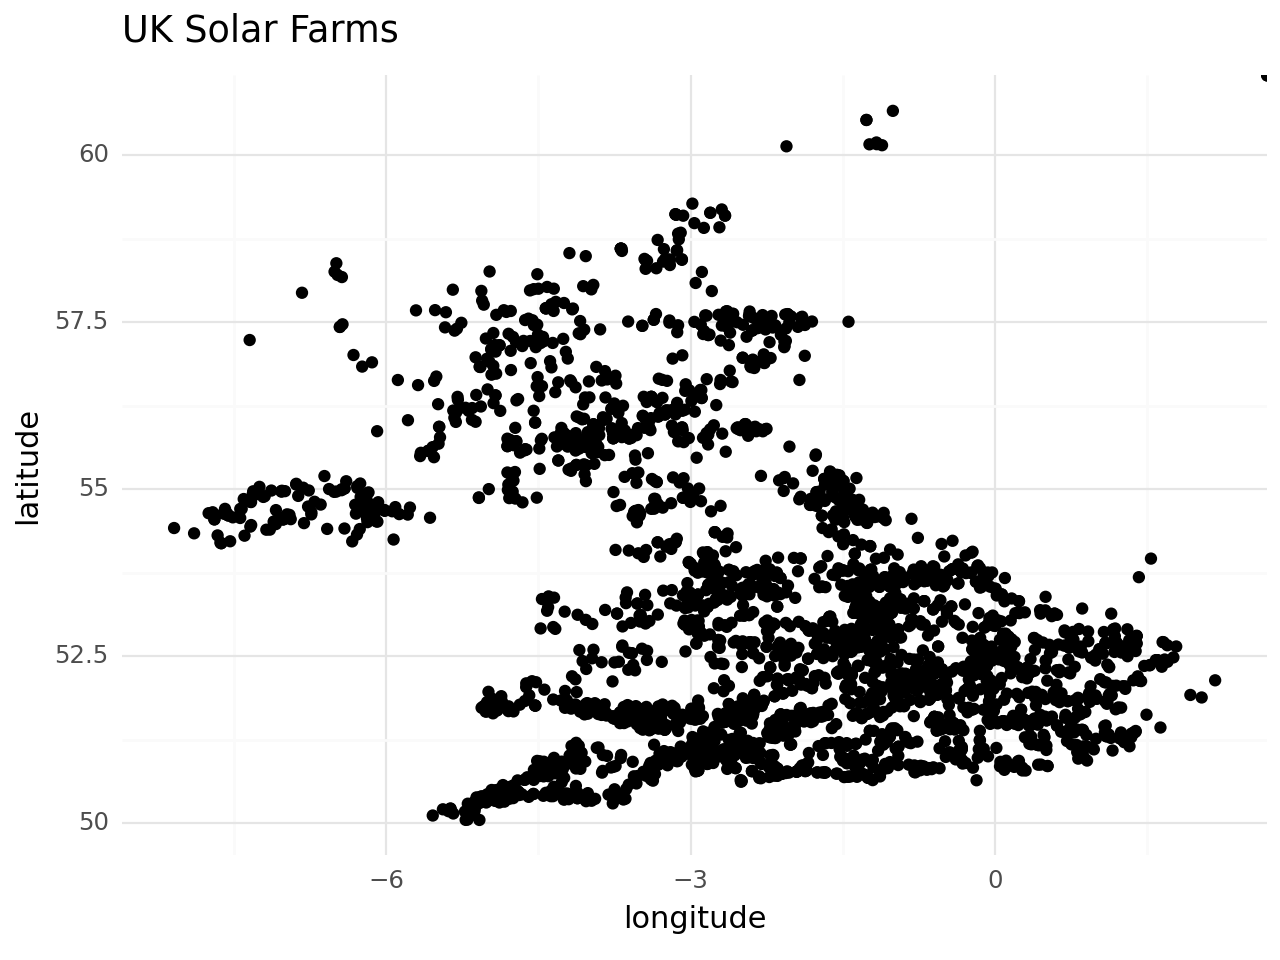

<Figure Size: (640 x 480)>

In [26]:
# Create ggplot
plot = (
    ggplot(gdf_UK_solar_coordinates) +
    geom_point(aes(x='longitude', y='latitude')) +
    theme_minimal() +
    ggtitle('UK Solar Farms')
)

plot

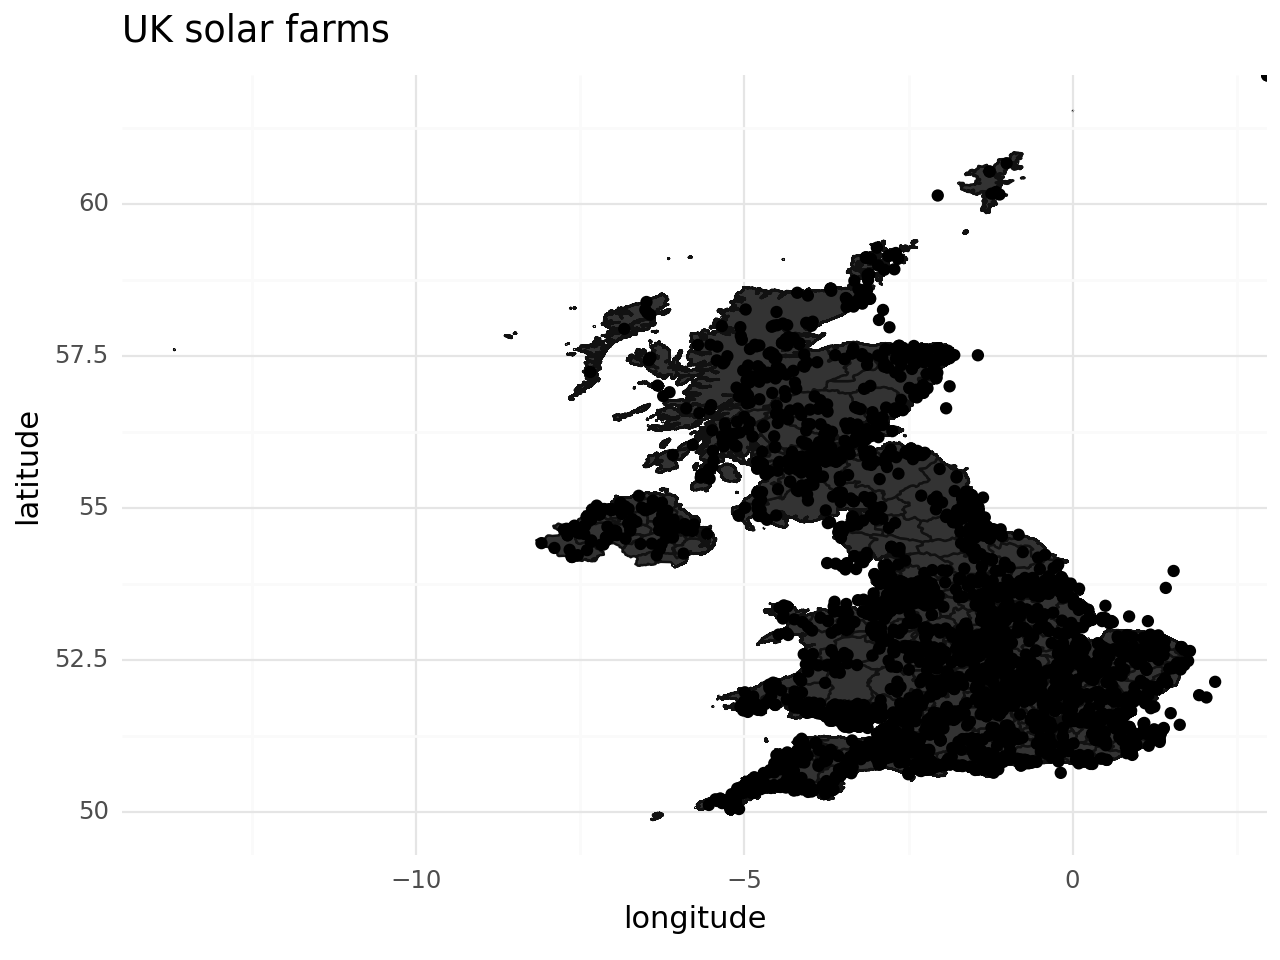

<Figure Size: (640 x 480)>

In [27]:
# Plot the base map and points
solar = (
    ggplot() +
    geom_map(gdf_GBR_3) +
    geom_point(data=gdf_UK_solar_coordinates, mapping=aes(x='longitude', y='latitude')) + #
    theme_minimal() +
    ggtitle('UK solar farms')
)

solar

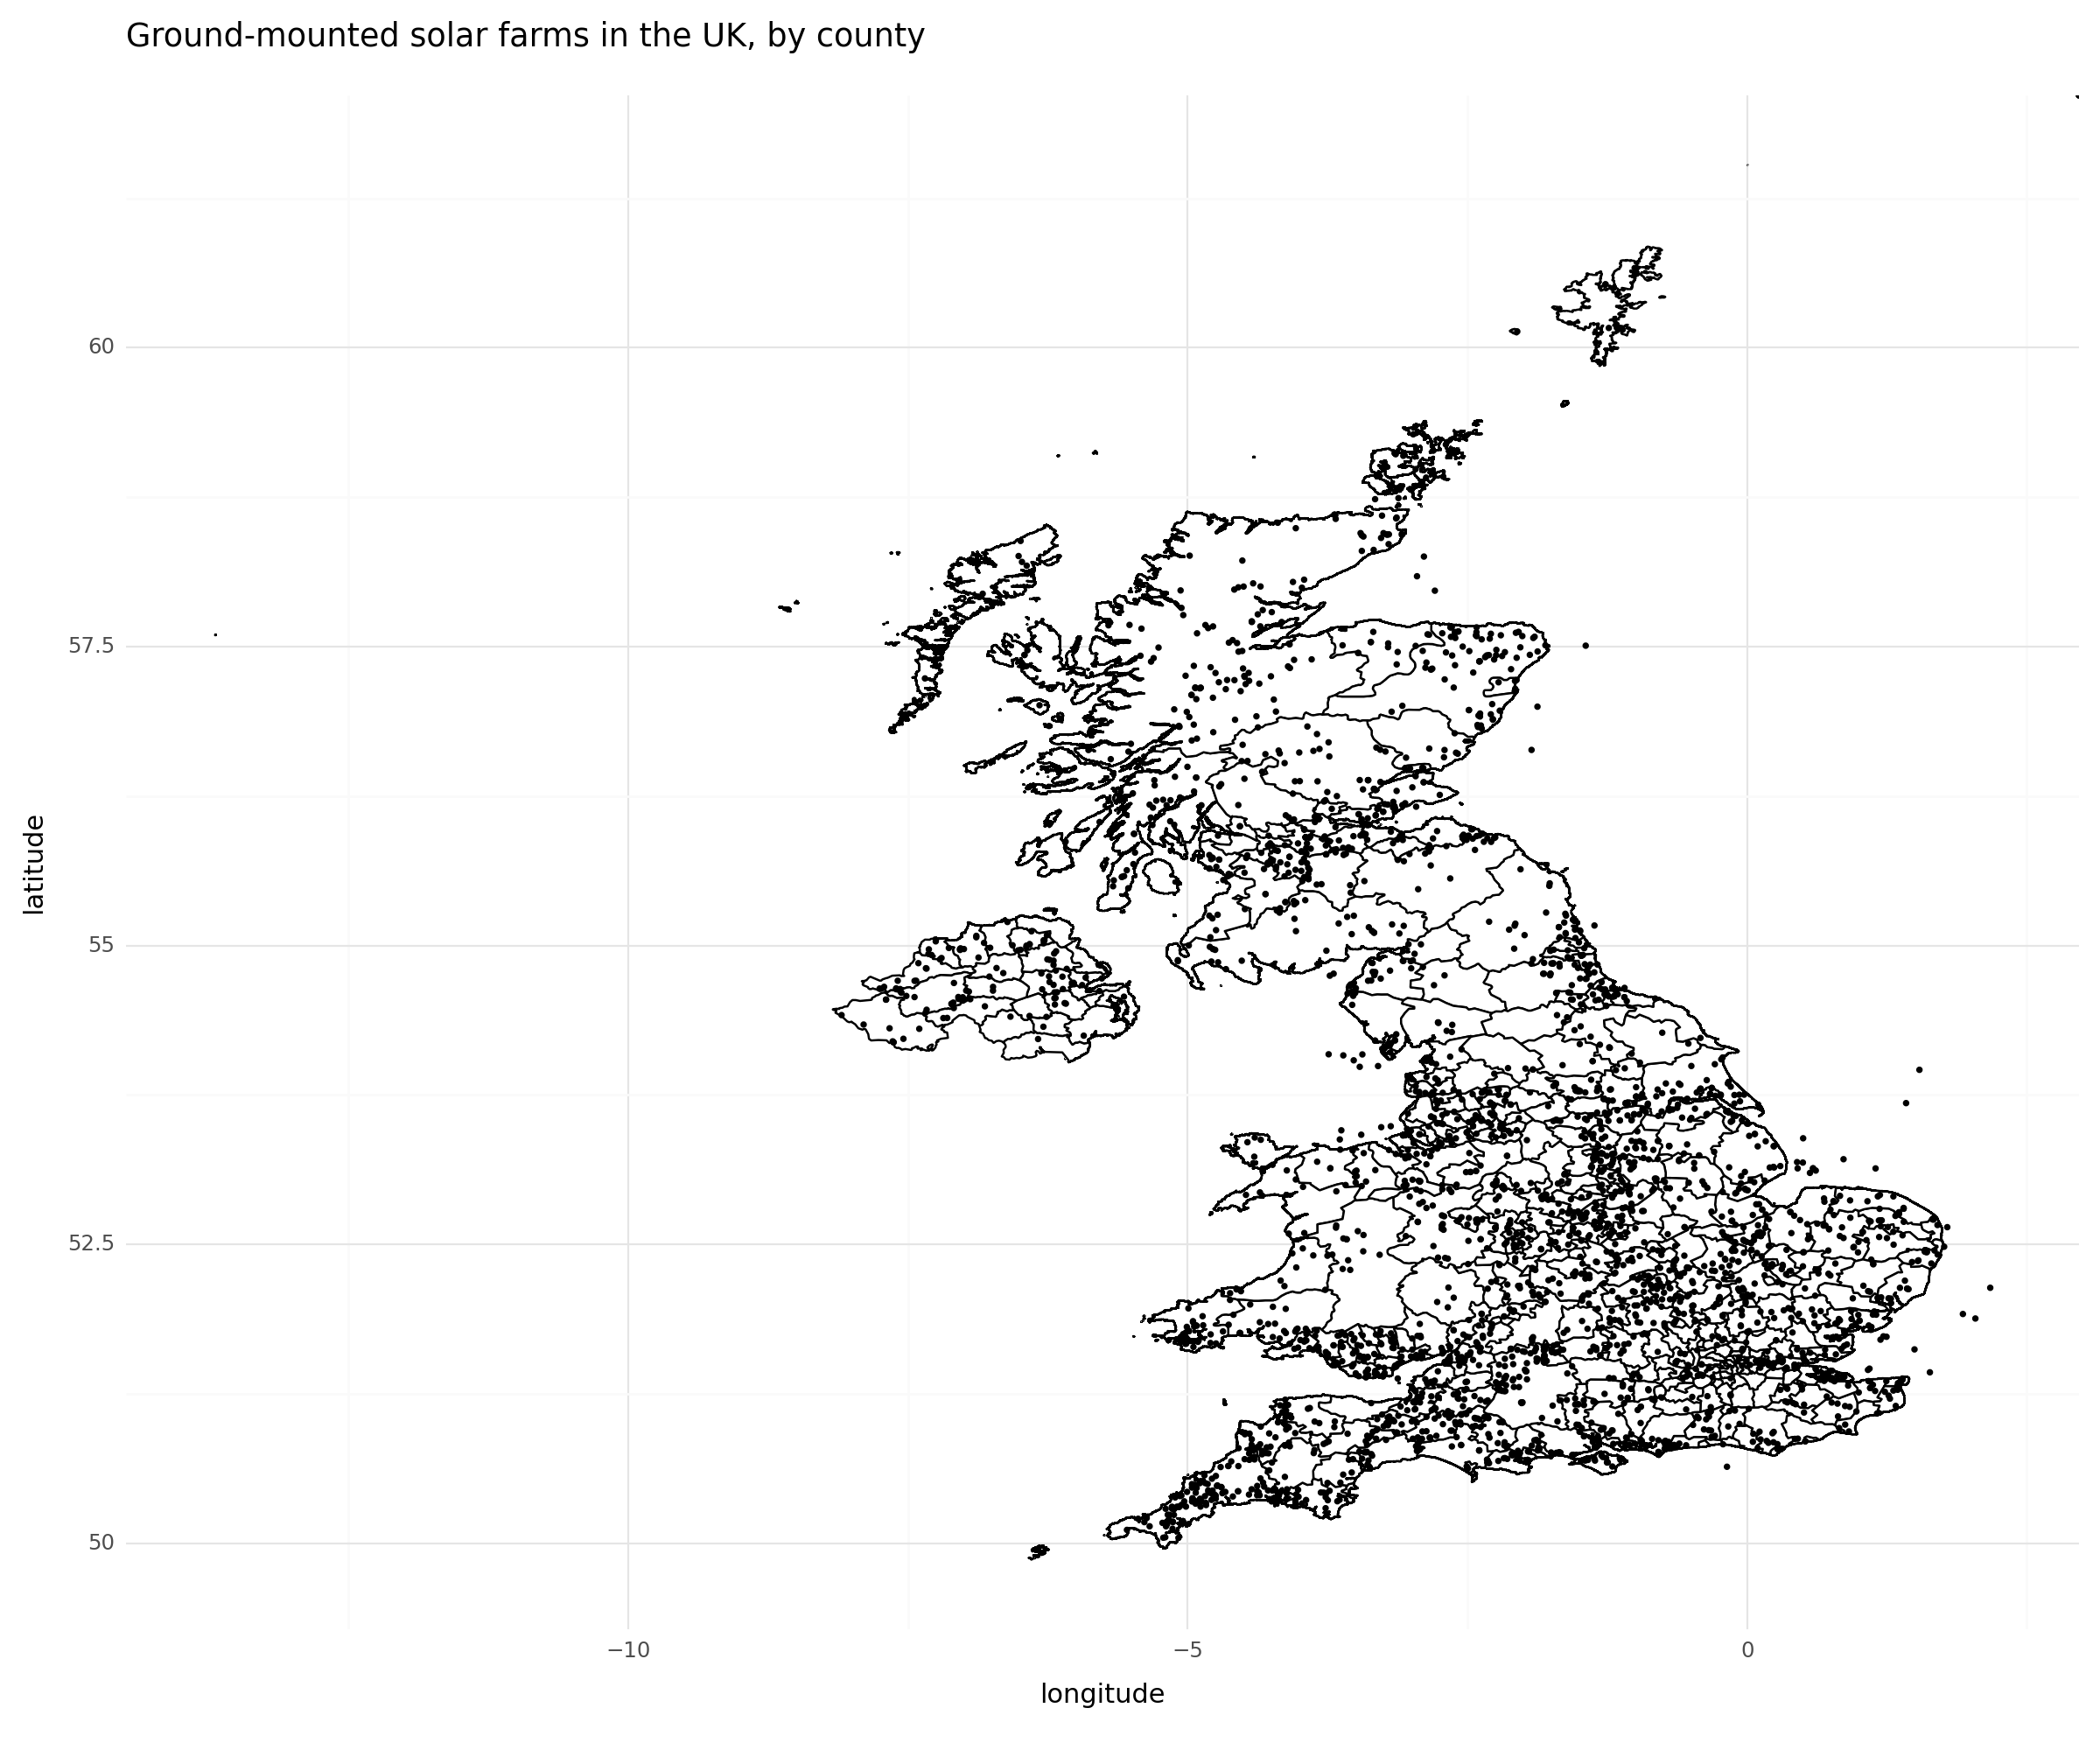

<Figure Size: (1200 x 1000)>

In [28]:
#Format for readability and plot final map
UK_solar_farms = (
    (ggplot() +
    geom_map(gdf_GBR_3, fill='white', color='black') +
    geom_point(data=gdf_UK_solar_coordinates, mapping=aes(x='longitude', y='latitude'), size=0.5) +
    theme_minimal() +
    theme(figure_size=(12, 10)) +
    ggtitle('Ground-mounted solar farms in the UK, by county'))
)

UK_solar_farms

# 1e) Solar farm and county relationships as heatmaps

In [29]:
# Convert df_UK_solar_coordinates to GeoDataFrame
geometry = [Point(xy) for xy in zip(gdf_UK_solar_coordinates['longitude'], gdf_UK_solar_coordinates['latitude'])]
gdf_UK_solar_coordinates = gpd.GeoDataFrame(gdf_UK_solar_coordinates, geometry=geometry, crs="EPSG:4326")

# Perform spatial join
gdf_merged = sjoin(gdf_UK_solar_coordinates, gdf_GBR_3, how="inner", op="within")

# Print the merged GeoDataFrame
gdf_merged.head()

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.


X-coordinate  Y-coordinate  longitude   latitude  \
0         302219.0      166320.0  -3.406610  51.387471   
1217      294767.0      178755.0  -3.517365  51.497907   
1439      307823.0      169675.0  -3.326971  51.418568   
1465      295957.0      170244.0  -3.497722  51.421627   
1493      303612.0      173658.0  -3.388595  51.453670   

                       geometry  index_right GID_0          NAME_0    GID_1  \
0     POINT (-3.40661 51.38747)          404   GBR  United Kingdom  GBR.4_1   
1217  POINT (-3.51737 51.49791)          404   GBR  United Kingdom  GBR.4_1   
1439  POINT (-3.32697 51.41857)          404   GBR  United Kingdom  GBR.4_1   
1465  POINT (-3.49772 51.42163)          404   GBR  United Kingdom  GBR.4_1   
1493  POINT (-3.38859 51.45367)          404   GBR  United Kingdom  GBR.4_1   

     NAME_1  ...             NAME_2 NL_NAME_2         GID_3  \
0     Wales  ...  Vale of Glamorgan      None  GBR.4.21.1_1   
1217  Wales  ...  Vale of Glamorgan      None  GBR.4.21.1_1   
1439  Wales  ...  Vale of Glamorgan      None  GBR.4.21.1_1   
1465  Wales  ...  Vale of Glamorgan      None  GBR.4.21.1_1   
1493  Wales  ...  Vale of Glamorgan      None  GBR.4.21.1_1   

                 NAME_3 VARNAME_3 NL_NAME_3                     TYPE_3  \
0     Vale of Glamorgan      None      None  Unitary authority (Wales)   
1217  Vale of Glamorgan      None      None  Unitary authority (Wales)   
1439  Vale of Glamorgan      None      None  Unitary authority (Wales)   
1465  Vale of Glamorgan      None      None  Unitary authority (Wales)   
1493  Vale of Glamorgan      None      None  Unitary authority (Wales)   

                      ENGTYPE_3  CC_3    HASC_3  
0     Unitary authority (Wales)  None  GB.VG.VG  
1217  Unitary authority (Wales)  None  GB.VG.VG  
1439  Unitary authority (Wales)  None  GB.VG.VG  
1465  Unitary authority (Wales)  None  GB.VG.VG  
1493  Unitary authority (Wales)  None  GB.VG.VG  

[5 rows x 22 columns]

In [30]:
# Check column names in gdf_GBR_3
gdf_GBR_3.columns

Index(['GID_0', 'NAME_0', 'GID_1', 'NAME_1', 'NL_NAME_1', 'GID_2', 'NAME_2',
       'NL_NAME_2', 'GID_3', 'NAME_3', 'VARNAME_3', 'NL_NAME_3', 'TYPE_3',
       'ENGTYPE_3', 'CC_3', 'HASC_3', 'geometry'],
      dtype='object')

In [31]:
gdf_GBR_3.head()

GID_0          NAME_0    GID_1   NAME_1 NL_NAME_1      GID_2  \
0   GBR  United Kingdom  GBR.1_1  England      None  GBR.1.1_1   
1   GBR  United Kingdom  GBR.1_1  England      None  GBR.1.2_1   
2   GBR  United Kingdom  GBR.1_1  England      None  GBR.1.3_1   
3   GBR  United Kingdom  GBR.1_1  England      None  GBR.1.4_1   
4   GBR  United Kingdom  GBR.1_1  England      None  GBR.1.5_1   

                         NAME_2 NL_NAME_2        GID_3  \
0                      Barnsley      None  GBR.1.1.1_1   
1  Bath and North East Somerset      None  GBR.1.2.1_1   
2                  Bedfordshire      None  GBR.1.3.1_1   
3                    Birmingham      None  GBR.1.4.1_1   
4         Blackburn with Darwen      None  GBR.1.5.1_1   

                         NAME_3 VARNAME_3 NL_NAME_3  \
0                      Barnsley      None      None   
1  Bath and North East Somerset      None      None   
2                       Bedford      None      None   
3                    Birmingham      None      None   
4         Blackburn with Darwen      None      None   

                        TYPE_3                    ENGTYPE_3  CC_3    HASC_3  \
0         Metropolitan borough         Metropolitan borough  None  GB.BX.BX   
1            Unitary authority            Unitary authority  None  GB.BN.BN   
2            Unitary authority            Unitary authority  None  GB.FO.FO   
3  Metropolitan borough (city)  Metropolitan borough (city)  None  GB.BI.BI   
4            Unitary authority            Unitary authority  None  GB.BW.BW   

                                            geometry  
0  POLYGON ((-1.78997 53.47293, -1.79306 53.47778...  
1  POLYGON ((-2.68629 51.31516, -2.68066 51.32836...  
2  POLYGON ((-0.58508 52.11364, -0.58806 52.11805...  
3  POLYGON ((-1.73417 52.51014, -1.73984 52.50894...  
4  POLYGON ((-2.51111 53.63377, -2.51317 53.63582...

In [32]:
gdf_GBR_3.shape

(406, 17)

In [33]:
# Group by county and count the number of points
county_counts = gdf_merged.groupby('NAME_2').size().reset_index(name='point_count')

# Display the result
county_counts.head()

NAME_2  point_count
0                 Aberdeen            5
1            Aberdeenshire           73
2                 Anglesey            5
3                    Angus            7
4  Antrim and Newtownabbey           14

In [34]:
# Merge the counts back into gdf_GBR_3
gdf_GBR_3_with_count = gdf_GBR_3.merge(county_counts, on='NAME_2', how='left')

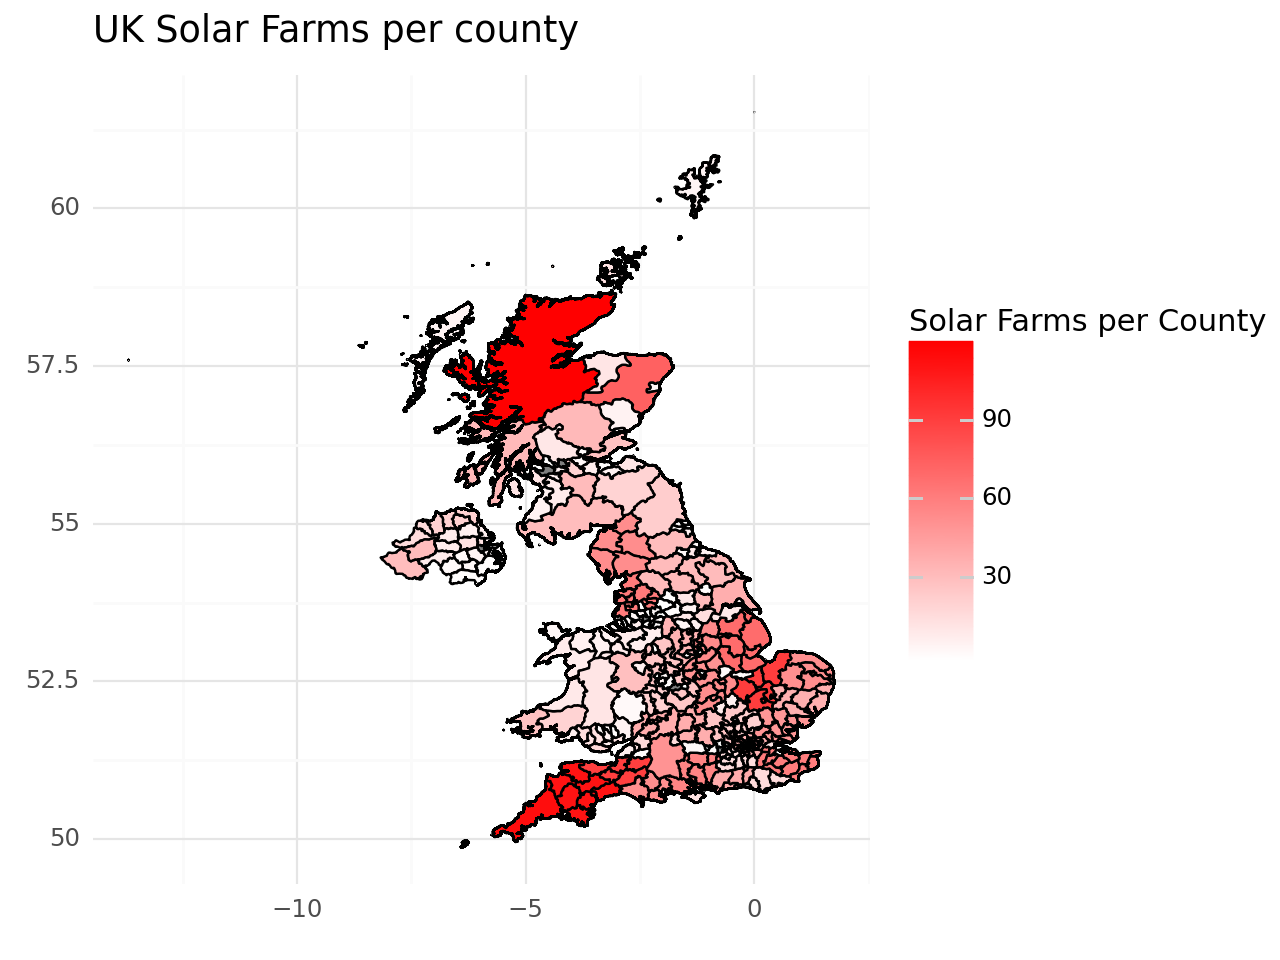

<Figure Size: (640 x 480)>

In [35]:
# Create a heatmap
heatmap = (
    ggplot(gdf_GBR_3_with_count) +
    geom_map(aes(fill='point_count'), color='black') +
    scale_fill_gradient(low='white', high='red') +
    theme_minimal() +
    ggtitle('UK Solar Farms per county') +
    labs(fill='Solar Farms per County')
)

heatmap

# 1f) Heatmap of solar farms density by county
On the above map, some counties may appear to have a larger number of solar farms given their larger land area. To account for this, let's create a heatmap measuring solar farm density per county.

In [36]:
# For density calculation to work correctly, need to switch to a British CRS where the unit is meters
gdf_density = gdf_GBR_3_with_count.to_crs("EPSG:27700")

In [37]:
# Calculate the area of each county
gdf_density['area_km2'] = gdf_density.geometry.area / 10**6  # Convert to square kilometers
print(gdf_density.geometry.area)

# Calculate the density of solar farms (solar farms per square kilometer)
gdf_density['density'] = gdf_density['point_count'] / gdf_density['area_km2']

# Sort the dataframe by density in descending order and keep the highest density per county
gdf_highest_density = gdf_density.sort_values(by='density', ascending=False).drop_duplicates(subset='NAME_2', keep='first')

print(gdf_highest_density.head())

print(gdf_highest_density.length)

0      3.506097e+08
1      3.538560e+08
2      3.826478e+08
3      2.631702e+08
4      1.368940e+08
           ...     
401    4.021793e+08
402    3.788249e+08
403    1.750496e+08
404    3.295609e+08
405    5.484177e+08
Length: 406, dtype: float64
    GID_0          NAME_0    GID_1   NAME_1 NL_NAME_1       GID_2  \
109   GBR  United Kingdom  GBR.1_1  England      None  GBR.1.36_1   
125   GBR  United Kingdom  GBR.1_1  England      None  GBR.1.38_1   
18    GBR  United Kingdom  GBR.1_1  England      None  GBR.1.16_1   
181   GBR  United Kingdom  GBR.1_1  England      None  GBR.1.51_1   
46    GBR  United Kingdom  GBR.1_1  England      None  GBR.1.26_1   

             NAME_2 NL_NAME_2          GID_3             NAME_3 VARNAME_3  \
109  Greater London      None  GBR.1.36.23_1             London      None   
125       Hampshire      None   GBR.1.38.5_1            Gosport      None   
18   Cambridgeshire      None   GBR.1.16.1_1          Cambridge      None   
181  Leicestershire      None

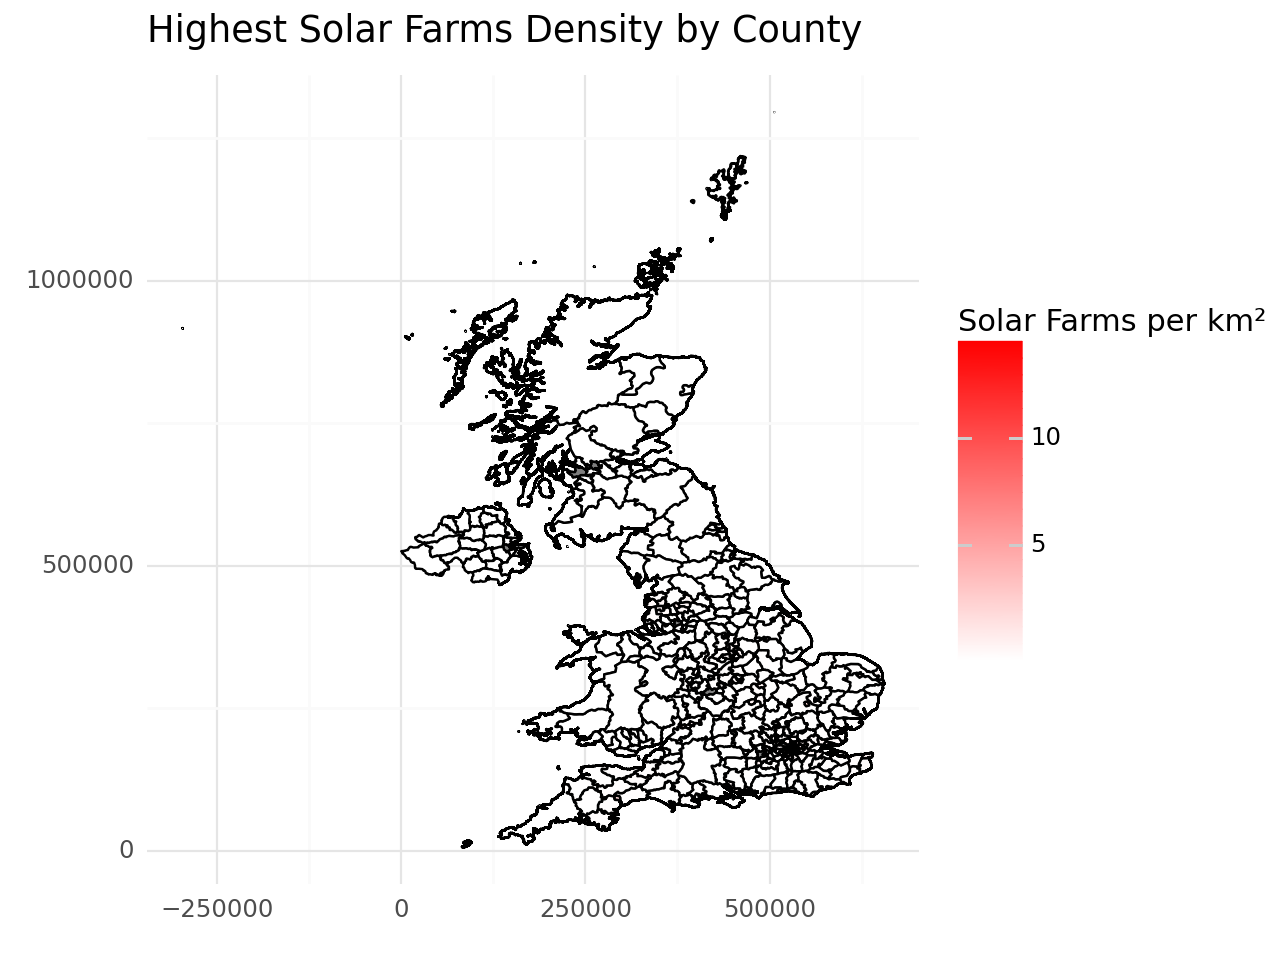

<Figure Size: (640 x 480)>

In [38]:
# Create a heatmap
heatmap_density = (
    ggplot(gdf_density) +
    geom_map(aes(fill='density'), color='black') +
    scale_fill_gradient(low='white', high='red') +
    theme_minimal() +
    ggtitle('Highest Solar Farms Density by County') +
    labs(fill='Solar Farms per km²')
)

heatmap_density

Issue: the base map is plotting, but we're not seeing the expected color range on our heat map. Let's investigate further!

In [39]:
gdf_density.describe()

point_count      area_km2     density
count   394.000000    406.000000  394.000000
mean     31.928934    604.495433    0.285298
std      25.336916   1552.460417    0.828316
min       1.000000      2.540693    0.001831
25%       8.250000     91.101706    0.023538
50%      31.000000    277.703289    0.065318
75%      50.000000    607.824587    0.220477
max     117.000000  26225.491403   14.169362

The solar farm densities per county are mostly very low (min = 0.0018, 25% = 0.024, 50% = 0.065, 75% = 0.22). The max is far, far higher at 14.16, which suggests we may have an outlier which is in turn throwing off the color scale of the heat map. Let's investigate further!

In [40]:
gdf_density.sort_values(by='density', ascending=False).head(20)

GID_0          NAME_0    GID_1   NAME_1 NL_NAME_1        GID_2  \
109   GBR  United Kingdom  GBR.1_1  England      None   GBR.1.36_1   
105   GBR  United Kingdom  GBR.1_1  England      None   GBR.1.36_1   
104   GBR  United Kingdom  GBR.1_1  England      None   GBR.1.36_1   
125   GBR  United Kingdom  GBR.1_1  England      None   GBR.1.38_1   
18    GBR  United Kingdom  GBR.1_1  England      None   GBR.1.16_1   
181   GBR  United Kingdom  GBR.1_1  England      None   GBR.1.51_1   
98    GBR  United Kingdom  GBR.1_1  England      None   GBR.1.36_1   
46    GBR  United Kingdom  GBR.1_1  England      None   GBR.1.26_1   
97    GBR  United Kingdom  GBR.1_1  England      None   GBR.1.36_1   
75    GBR  United Kingdom  GBR.1_1  England      None   GBR.1.33_1   
184   GBR  United Kingdom  GBR.1_1  England      None   GBR.1.52_1   
119   GBR  United Kingdom  GBR.1_1  England      None   GBR.1.36_1   
116   GBR  United Kingdom  GBR.1_1  England      None   GBR.1.36_1   
92    GBR  United Kingdom  GBR.1_1  England      None   GBR.1.36_1   
127   GBR  United Kingdom  GBR.1_1  England      None   GBR.1.38_1   
107   GBR  United Kingdom  GBR.1_1  England      None   GBR.1.36_1   
312   GBR  United Kingdom  GBR.1_1  England      None  GBR.1.110_1   
200   GBR  United Kingdom  GBR.1_1  England      None   GBR.1.59_1   
114   GBR  United Kingdom  GBR.1_1  England      None   GBR.1.36_1   
99    GBR  United Kingdom  GBR.1_1  England      None   GBR.1.36_1   

             NAME_2 NL_NAME_2          GID_3                  NAME_3  \
109  Greater London      None  GBR.1.36.23_1                  London   
105  Greater London      None  GBR.1.36.19_1  Kensington and Chelsea   
104  Greater London      None  GBR.1.36.18_1               Islington   
125       Hampshire      None   GBR.1.38.5_1                 Gosport   
18   Cambridgeshire      None   GBR.1.16.1_1               Cambridge   
181  Leicestershire      None   GBR.1.51.7_1       Oadby and Wigston   
98   Greater London      None  GBR.1.36.12_1  Hammersmith and Fulham   
46            Devon      None   GBR.1.26.2_1                  Exeter   
97   Greater London      None  GBR.1.36.11_1                 Hackney   
75            Essex      None   GBR.1.33.8_1                  Harlow   
184    Lincolnshire      None   GBR.1.52.3_1                 Lincoln   
119  Greater London      None  GBR.1.36.33_1             Westminster   
116  Greater London      None  GBR.1.36.30_1           Tower Hamlets   
92   Greater London      None   GBR.1.36.6_1                  Camden   
127       Hampshire      None   GBR.1.38.7_1                  Havant   
107  Greater London      None  GBR.1.36.21_1                 Lambeth   
312     West Sussex      None  GBR.1.110.7_1                Worthing   
200         Norfolk      None   GBR.1.59.5_1                 Norwich   
114  Greater London      None  GBR.1.36.28_1               Southwark   
99   Greater London      None  GBR.1.36.13_1                Haringey   

    VARNAME_3 NL_NAME_3                          TYPE_3  \
109      None      None           London borough (city)   
105      None      None          London borough (royal)   
104      None      None                  London borough   
125      None      None  Administrative county district   
18       None      None  Administrative county district   
181      None      None  Administrative county district   
98       None      None                  London borough   
46       None      None  Administrative county district   
97       None      None                  London borough   
75       None      None  Administrative county district   
184      None      None  Administrative county district   
119      None      None           London borough (city)   
116      None      None                  London borough   
92       None      None                  London borough   
127      None      None  Administrative county district   
107      None      None                  London borough   
312      None    

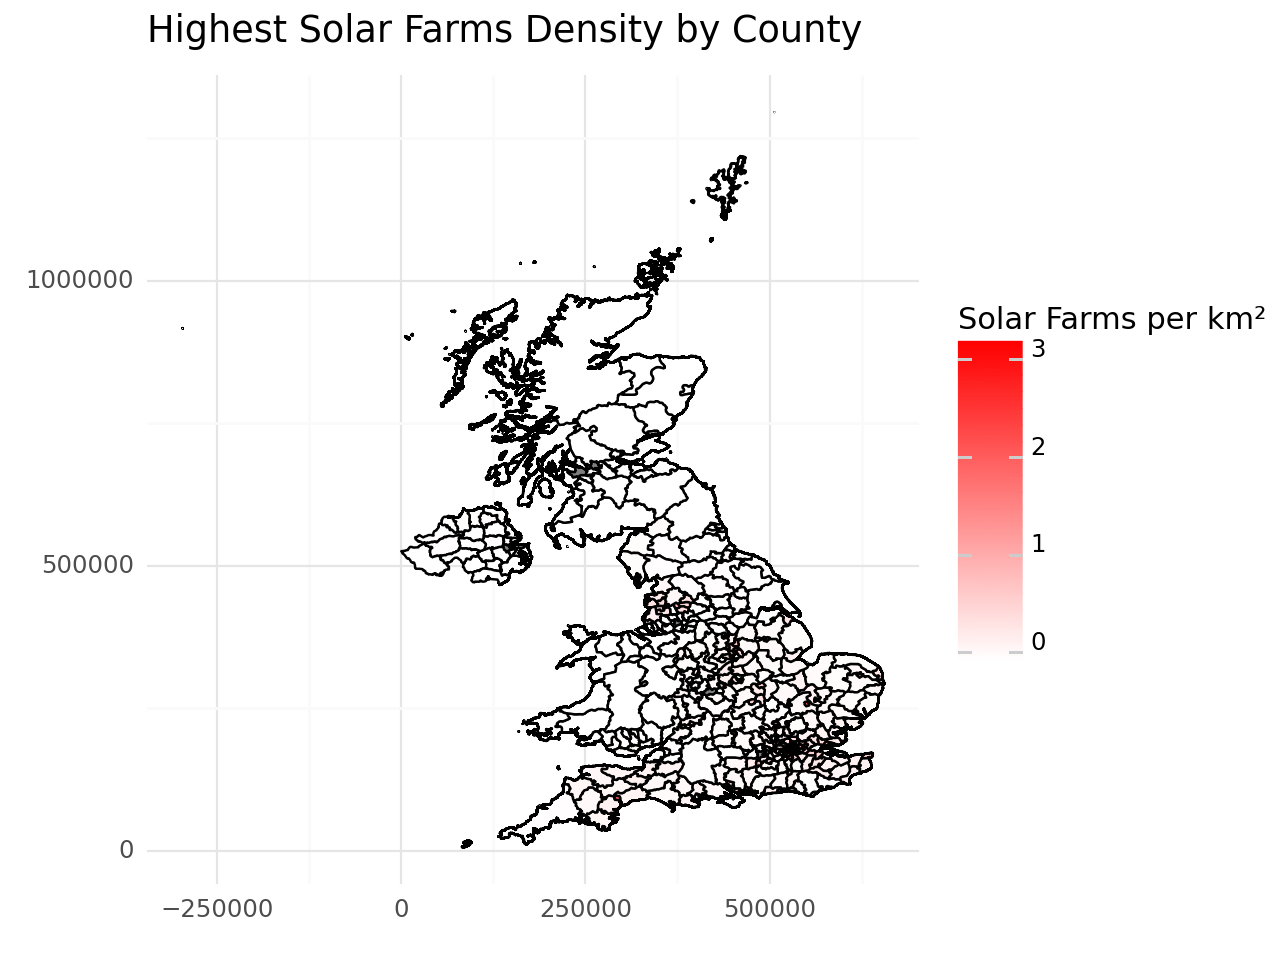

<Figure Size: (640 x 480)>

In [41]:
# Create a heatmap
heatmap_density = (
    ggplot(gdf_density) +
    geom_map(aes(fill='density'), color='black') +
    scale_fill_gradient(low='white', high='red', limits=[3.1,0]) +
    theme_minimal() +
    ggtitle('Highest Solar Farms Density by County') +
    labs(fill='Solar Farms per km²')
)

heatmap_density

Greater London appears to be skewing our map with a density of 14.169362 solar farms per km2. Setting the scale of the heatmap to 3.1 (the value of our next densest county) is slightly more helpful in revelaing the trend. However, we still have a number of extremely small counties, especially around London where urban commercial solar is more prevalent. Given that we are particularly focused on rural and agricultural opportunitues for solar, let's lower the upper limit of the scale to 0.3 (still well above the 0.2 density of the 75%) to examine the trends.

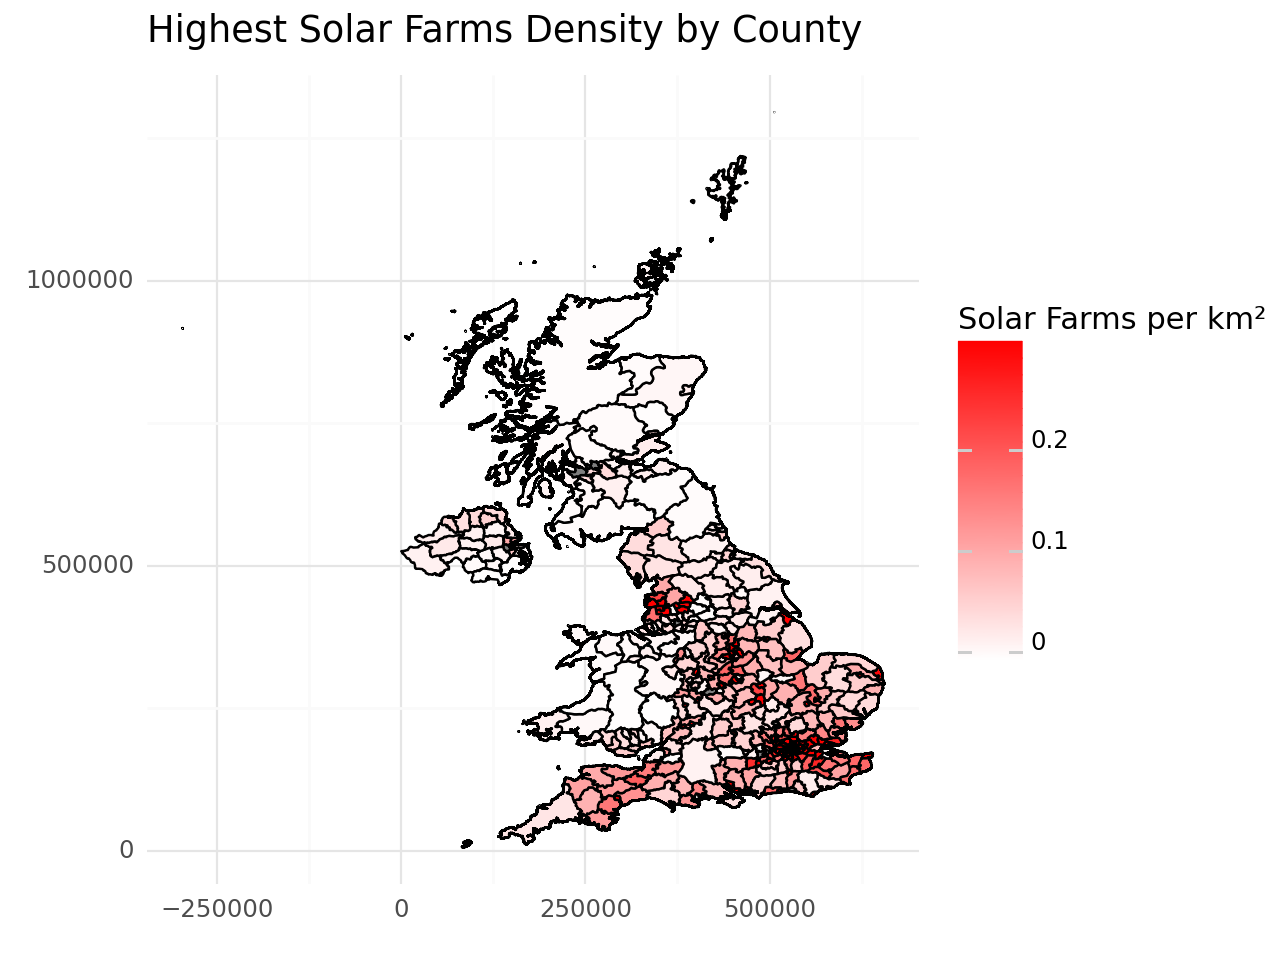

<Figure Size: (640 x 480)>

In [42]:
# Create a heatmap
heatmap_density = (
    ggplot(gdf_density) +
    geom_map(aes(fill='density'), color='black') +
    scale_fill_gradient(low='white', high='red', limits=[0.3,0]) +
    theme_minimal() +
    ggtitle('Highest Solar Farms Density by County') +
    labs(fill='Solar Farms per km²')
)

heatmap_density

This makes it much easier to see the differences in density (and confirms our hypothesis that urban solar is prevalent in central and greater London!).

# Question 2: Which UK counties have sufficient solar hours to make solar energy commercially viable?
- Sunlight data. Use astral package with coordinate data for each county to create a new column that has the sunlight data by county for December 22, 2023 (winter solstice).
- Find out minimum viable sunlight hours for commercial solar operation. Create map where anything more that that number of hours is green, all other counties red (non-viable/not optimal).

The accessibility to data meant that we were only able to find nationwide data on sunlight hours. We aknowledge the importance of looking at solar intensity in addition to sunlight hours.

In [43]:
# Test using London
city_name = 'England'
latitude = 52.3555
longitude = -1.1743
location = LocationInfo(name=city_name, latitude=latitude, longitude=longitude)

In [45]:
location = LocationInfo(name='London', region='England', timezone='Europe/London', latitude=51.5074, longitude=-0.1278)

today = date.today()
sun_times = sun(location.observer, date=today)

daylight_duration = sun_times['sunset'] - sun_times['sunrise']

total_seconds = daylight_duration.total_seconds()

#rounding to nearest second
minutes = round(total_seconds / 60)

print('Sunrise:', sun_times['sunrise'])
print('Sunset:', sun_times['sunset'])
print('Daylight duration (rounded to the nearest minute):', minutes, 'minutes')

Sunrise: 2024-04-29 04:35:43.273032+00:00
Sunset: 2024-04-29 19:20:58.219400+00:00
Daylight duration (rounded to the nearest minute): 885 minutes


In [46]:
# Open the CSV file using pandas
df = pd.read_csv("https://raw.githubusercontent.com/envirodatascience/final-project-agrivoltaics/main/df_UK_solar_filtered%20(12).csv")

# Print the DataFrame
df

Site Name  X-coordinate  \
0                        Aberthaw Power Station Biomass      302219.0   
1                         Ferrybridge Multifuel 2 (FM2)      447490.0   
2                        Thetford Biomass Power Station      585300.0   
3                                  Chilton Energy Plant      428049.0   
4                      Double H Nurseries Biomass Plant      422804.0   
...                                                 ...           ...   
2947                        LVF Packaging - Solar Panel      431334.0   
2948  Elstree Film And TV Studios, Shenley Road - So...      519788.0   
2949                      F Lloyd Penley - Solar Panels      337383.0   
2950  Fairham Business Park, Foresters Avenue  - Roo...      453576.0   
2951                            Roskilly's - Solar Farm      179412.0   

      Y-coordinate  
0         166320.0  
1         424684.0  
2         286900.0  
3         530414.0  
4          94625.0  
...            ...  
2947      431974.0  
2948      196844.0  
2949      348803.0  
2950      332916.0  
2951       20706.0  

[2952 rows x 3 columns]

In [47]:
input_crs = pyproj.CRS('EPSG:27700')
output_crs = pyproj.CRS('EPSG:4326')
transformer = pyproj.Transformer.from_crs(input_crs, output_crs)
df['Latitude'], df['Longitude'] = transformer.transform(df['X-coordinate'], df['Y-coordinate'])
df

Site Name  X-coordinate  \
0                        Aberthaw Power Station Biomass      302219.0   
1                         Ferrybridge Multifuel 2 (FM2)      447490.0   
2                        Thetford Biomass Power Station      585300.0   
3                                  Chilton Energy Plant      428049.0   
4                      Double H Nurseries Biomass Plant      422804.0   
...                                                 ...           ...   
2947                        LVF Packaging - Solar Panel      431334.0   
2948  Elstree Film And TV Studios, Shenley Road - So...      519788.0   
2949                      F Lloyd Penley - Solar Panels      337383.0   
2950  Fairham Business Park, Foresters Avenue  - Roo...      453576.0   
2951                            Roskilly's - Solar Farm      179412.0   

      Y-coordinate   Latitude  Longitude  
0         166320.0  51.387471  -3.406610  
1         424684.0  53.716417  -1.281885  
2         286900.0  52.448628   0.725273  
3         530414.0  54.668027  -1.566632  
4          94625.0  50.750782  -1.678119  
...            ...        ...        ...  
2947      431974.0  53.783154  -1.525941  
2948      196844.0  51.657627  -0.269673  
2949      348803.0  53.032826  -2.935187  
2950      332916.0  52.891035  -1.205138  
2951       20706.0  50.045512  -5.082375  

[2952 rows x 5 columns]

In [50]:
# Load the CSV file into a DataFrame
df

# Define a function to calculate daylight hours
def calculate_daylight_hours(latitude, longitude, date_today):
    location = LocationInfo(latitude=latitude, longitude=longitude)
    try:
        sun_times = sun(location.observer, date=date_today)
        sunrise = sun_times['sunrise']
        sunset = sun_times['sunset']
        daylight_duration = sunset - sunrise
        return daylight_duration.total_seconds() / 60  # Convert to minutes and return
    except ValueError as e:
        print(f"Sunlight calculation error at latitude {latitude} and longitude {longitude}: {e}")
        return 0  # Return 0 minutes for cases where no valid sunrise/sunset could be calculated

# Current date
today = date(2023, 12, 22)

# Calculate daylight duration for each row in the DataFrame
df['Daylight Duration (minutes)'] = df.apply(lambda row: calculate_daylight_hours(row['Latitude'], row['Longitude'], today), axis=1)

# Display the updated DataFrame
print(df)

df_sorted = df.sort_values(by='Daylight Duration (minutes)', ascending=False)

# Display the sorted DataFrame
df_sorted

Sunlight calculation error at latitude inf and longitude inf: Sun never reaches 6 degrees below the horizon, at this location.
Sunlight calculation error at latitude inf and longitude inf: Sun never reaches 6 degrees below the horizon, at this location.
                                              Site Name  X-coordinate  \
0                        Aberthaw Power Station Biomass      302219.0   
1                         Ferrybridge Multifuel 2 (FM2)      447490.0   
2                        Thetford Biomass Power Station      585300.0   
3                                  Chilton Energy Plant      428049.0   
4                      Double H Nurseries Biomass Plant      422804.0   
...                                                 ...           ...   
2947                        LVF Packaging - Solar Panel      431334.0   
2948  Elstree Film And TV Studios, Shenley Road - So...      519788.0   
2949                      F Lloyd Penley - Solar Panels      337383.0   
2950  Fairham Bu

Site Name  X-coordinate  \
2951                           Roskilly's - Solar Farm      179412.0   
779                               Goonhilly Downs - PV      169711.0   
1465                 Goonhilly Downs Wind Farm Repower      171000.0   
2868                     Lidl Foodstore - Solar Panels      146832.0   
780                         Higher Tregarne Solar Farm      175993.0   
...                                                ...           ...   
2631                              Shetland Tidal Array      440389.0   
2774                  Shetland Tidal Array (extension)      440389.0   
1697  North Yell Wind Farm (Garth Community Wind Farm)      454471.0   
837         Sainsbury's Stores (169 individual Stores)           NaN   
839         First Wessex Housing Properties (multiple)           NaN   

      Y-coordinate   Latitude  Longitude  Daylight Duration (minutes)  
2951       20706.0  50.045512  -5.082375                   483.275561  
779        21226.0  50.046506  -5.217964                   483.266211  
1465       21600.0  50.050362  -5.200213                   483.229881  
2868       29557.0  50.111997  -5.542429                   482.648231  
780        29329.0  50.121671  -5.135107                   482.556712  
...            ...        ...        ...                          ...  
2631     1183121.0  60.529655  -1.265939                   340.528903  
2774     1183121.0  60.529655  -1.265939                   340.528903  
1697     1198506.0  60.666108  -1.005165                   337.702376  
837            NaN        inf        inf                     0.000000  
839            NaN        inf        inf                     0.000000  

[2952 rows x 6 columns]

Let's also remove the multiple locations

In [51]:
df_filtered = df_sorted[df_sorted['Daylight Duration (minutes)'] > 0]
df_filtered

Site Name  X-coordinate  \
2951                           Roskilly's - Solar Farm      179412.0   
779                               Goonhilly Downs - PV      169711.0   
1465                 Goonhilly Downs Wind Farm Repower      171000.0   
2868                     Lidl Foodstore - Solar Panels      146832.0   
780                         Higher Tregarne Solar Farm      175993.0   
...                                                ...           ...   
2666      Northern Isles New Energy Solution (NINES) 1      446456.0   
1850                                Gremista Wind Farm      446287.0   
2631                              Shetland Tidal Array      440389.0   
2774                  Shetland Tidal Array (extension)      440389.0   
1697  North Yell Wind Farm (Garth Community Wind Farm)      454471.0   

      Y-coordinate   Latitude  Longitude  Daylight Duration (minutes)  
2951       20706.0  50.045512  -5.082375                   483.275561  
779        21226.0  50.046506  -5.217964                   483.266211  
1465       21600.0  50.050362  -5.200213                   483.229881  
2868       29557.0  50.111997  -5.542429                   482.648231  
780        29329.0  50.121671  -5.135107                   482.556712  
...            ...        ...        ...                          ...  
2666     1142794.0  60.166964  -1.164717                   347.839705  
1850     1145628.0  60.192426  -1.167118                   347.335713  
2631     1183121.0  60.529655  -1.265939                   340.528903  
2774     1183121.0  60.529655  -1.265939                   340.528903  
1697     1198506.0  60.666108  -1.005165                   337.702376  

[2950 rows x 6 columns]

Descriptive Statistics for Daylight Duration:
count    2950.000000
mean      449.269185
std        25.583510
min       337.702376
25%       434.064352
50%       456.802625
75%       468.649274
max       483.275561
Name: Daylight Duration (minutes), dtype: float64
Correlation matrix:


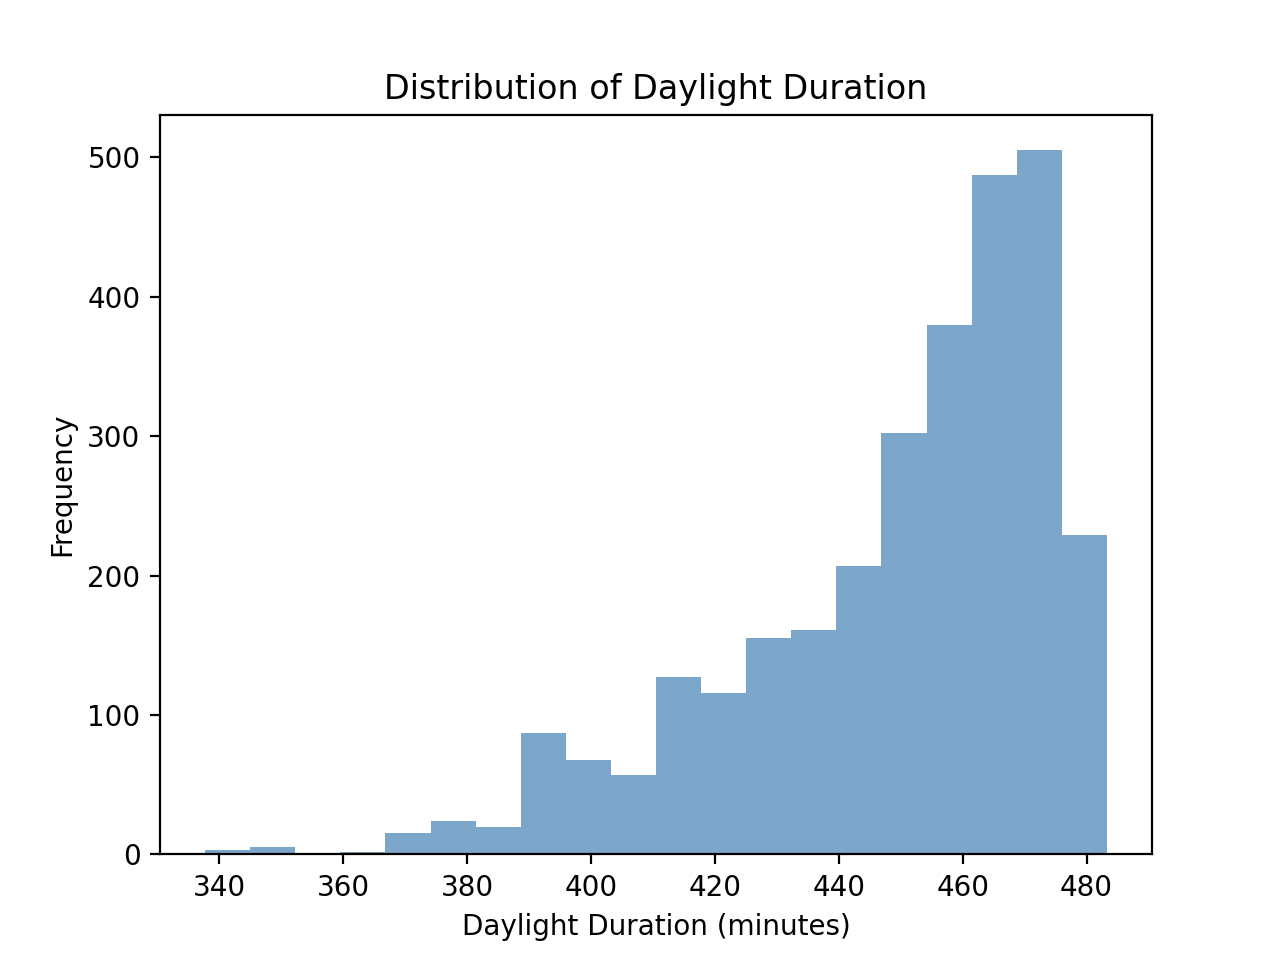

In [52]:
print("Descriptive Statistics for Daylight Duration:")
print(df_filtered['Daylight Duration (minutes)'].describe())

# Correlation matrix
print("Correlation matrix:")

# Histogram
import matplotlib.pyplot as plt
plt.hist(df_filtered['Daylight Duration (minutes)'], bins=20, color='steelblue', alpha=0.7)
plt.title('Distribution of Daylight Duration')
plt.xlabel('Daylight Duration (minutes)')
plt.ylabel('Frequency')
plt.show()

Solar farms with 4+ hours of peak sunlight hours hours are considered commercially viable. The UK does not have publicly-available data about solar irradience and peak sunlight hours, so we will look at results above and below the mean sunlight hours as a proxy.

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_ocean.zip
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip


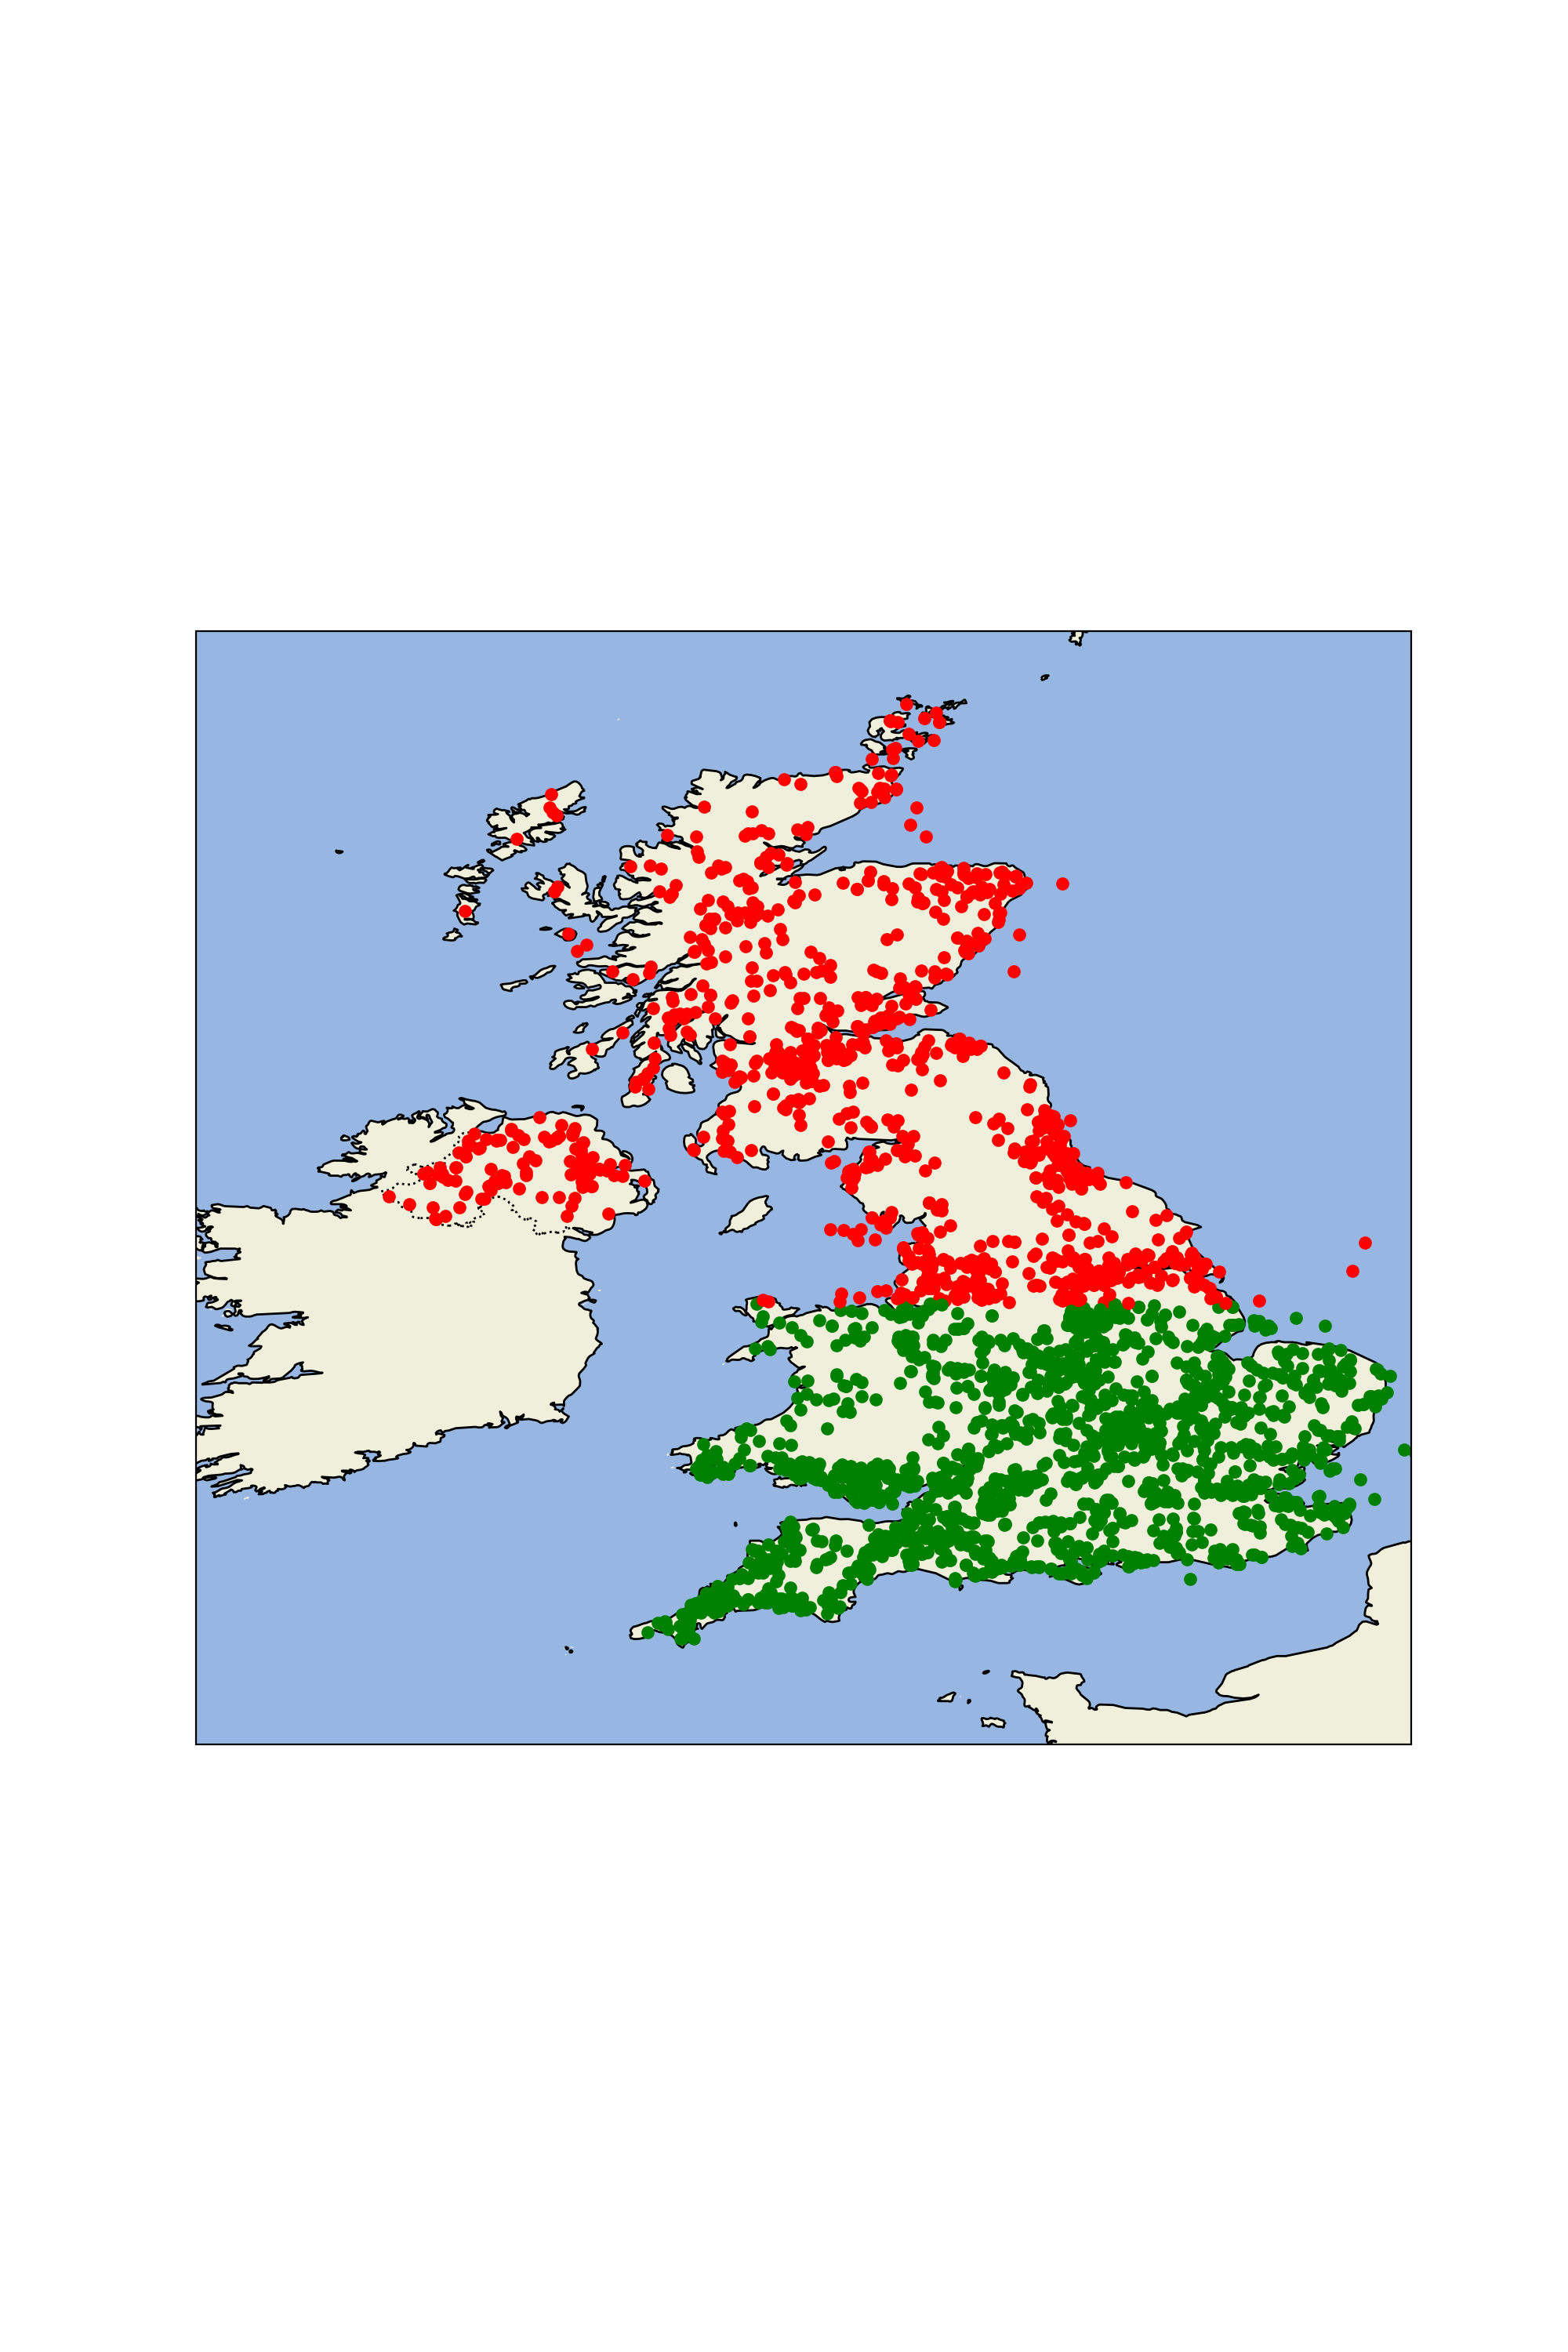

In [53]:
df_filtered = pd.DataFrame(df_filtered)

min_sunlight_hours = 449  # greater than the mean

# Create a map
fig = plt.figure(figsize=(10, 15))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-10, 2, 49, 60], crs=ccrs.PlateCarree())  # for the UK

ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')

# Plot each point
for i, row in df.iterrows():
    color = 'green' if row['Daylight Duration (minutes)'] >= min_sunlight_hours else 'red'
    ax.plot(row['Longitude'], row['Latitude'], color=color, marker='o', markersize=5, transform=ccrs.Geodetic())

plt.show()

In [54]:
min_sunlight_hours = 449
df_filtered['Meets Sunlight Criteria'] = df_filtered['Daylight Duration (minutes)'].apply(lambda x: 'yes' if x >= min_sunlight_hours else 'no')

# Question 3: Which UK counties have the greatest agricultural land area use?

DEFRA (the UK Department for Environment Food and Rural Affairs) only has data available land for regional agricultural land use in England (Northern Ireland, Scotland, and Wales data are not available). So we need to filter data for only counties within England, and then match them to the relevant English region.

In [55]:
gdf_GBR_3_with_count.columns

Index(['GID_0', 'NAME_0', 'GID_1', 'NAME_1', 'NL_NAME_1', 'GID_2', 'NAME_2',
       'NL_NAME_2', 'GID_3', 'NAME_3', 'VARNAME_3', 'NL_NAME_3', 'TYPE_3',
       'ENGTYPE_3', 'CC_3', 'HASC_3', 'geometry', 'point_count'],
      dtype='object')

In [56]:
#Filter data for just England
# Filter to keep only rows where 'Name_1' = 'England'
gdf_england = gdf_GBR_3_with_count[gdf_GBR_3_with_count['NAME_1'] == 'England']
gdf_england.head()

GID_0          NAME_0    GID_1   NAME_1 NL_NAME_1      GID_2  \
0   GBR  United Kingdom  GBR.1_1  England      None  GBR.1.1_1   
1   GBR  United Kingdom  GBR.1_1  England      None  GBR.1.2_1   
2   GBR  United Kingdom  GBR.1_1  England      None  GBR.1.3_1   
3   GBR  United Kingdom  GBR.1_1  England      None  GBR.1.4_1   
4   GBR  United Kingdom  GBR.1_1  England      None  GBR.1.5_1   

                         NAME_2 NL_NAME_2        GID_3  \
0                      Barnsley      None  GBR.1.1.1_1   
1  Bath and North East Somerset      None  GBR.1.2.1_1   
2                  Bedfordshire      None  GBR.1.3.1_1   
3                    Birmingham      None  GBR.1.4.1_1   
4         Blackburn with Darwen      None  GBR.1.5.1_1   

                         NAME_3 VARNAME_3 NL_NAME_3  \
0                      Barnsley      None      None   
1  Bath and North East Somerset      None      None   
2                       Bedford      None      None   
3                    Birmingham      None      None   
4         Blackburn with Darwen      None      None   

                        TYPE_3                    ENGTYPE_3  CC_3    HASC_3  \
0         Metropolitan borough         Metropolitan borough  None  GB.BX.BX   
1            Unitary authority            Unitary authority  None  GB.BN.BN   
2            Unitary authority            Unitary authority  None  GB.FO.FO   
3  Metropolitan borough (city)  Metropolitan borough (city)  None  GB.BI.BI   
4            Unitary authority            Unitary authority  None  GB.BW.BW   

                                            geometry  point_count  
0  POLYGON ((-1.78997 53.47293, -1.79306 53.47778...         11.0  
1  POLYGON ((-2.68629 51.31516, -2.68066 51.32836...          2.0  
2  POLYGON ((-0.58508 52.11364, -0.58806 52.11805...          8.0  
3  POLYGON ((-1.73417 52.51014, -1.73984 52.50894...          3.0  
4  POLYGON ((-2.51111 53.63377, -2.51317 53.63582...          1.0

In [57]:
#Check how many counties to match to region
gdf_england.shape

(326, 18)

In [58]:
#Export county data so we can match it to regional data
# Export DataFrame to CSV
gdf_england.to_csv('gdf_england.csv', index=False)

# Download the CSV file
from google.colab import files
files.download('gdf_england.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [59]:
#Import CSV with county matched to region
csv_file_path = 'https://raw.githubusercontent.com/envirodatascience/final-project-agrivoltaics/main/FINAL_gdf_england_regions%20-%20gdf_england%20(1).csv'

# Read the CSV file into a gdf
df_england_reg = pd.read_csv(csv_file_path)

In [60]:
#Preview df
df_england_reg.head()

GID_0          NAME_0    GID_1   NAME_1  NL_NAME_1      GID_2  \
0   GBR  United Kingdom  GBR.1_1  England        NaN  GBR.1.1_1   
1   GBR  United Kingdom  GBR.1_1  England        NaN  GBR.1.2_1   
2   GBR  United Kingdom  GBR.1_1  England        NaN  GBR.1.3_1   
3   GBR  United Kingdom  GBR.1_1  England        NaN  GBR.1.4_1   
4   GBR  United Kingdom  GBR.1_1  England        NaN  GBR.1.5_1   

                         NAME_2                     REGION  NL_NAME_2  \
0                      Barnsley   Yorkshire and The Humber        NaN   
1  Bath and North East Somerset                 South West        NaN   
2                  Bedfordshire  South East (incl. London)        NaN   
3                    Birmingham              West Midlands        NaN   
4         Blackburn with Darwen  North West and Merseyside        NaN   

         GID_3                        NAME_3  VARNAME_3  NL_NAME_3  \
0  GBR.1.1.1_1                      Barnsley        NaN        NaN   
1  GBR.1.2.1_1  Bath and North East Somerset        NaN        NaN   
2  GBR.1.3.1_1                       Bedford        NaN        NaN   
3  GBR.1.4.1_1                    Birmingham        NaN        NaN   
4  GBR.1.5.1_1         Blackburn with Darwen        NaN        NaN   

                        TYPE_3                    ENGTYPE_3  CC_3    HASC_3  \
0         Metropolitan borough         Metropolitan borough   NaN  GB.BX.BX   
1            Unitary authority            Unitary authority   NaN  GB.BN.BN   
2            Unitary authority            Unitary authority   NaN  GB.FO.FO   
3  Metropolitan borough (city)  Metropolitan borough (city)   NaN  GB.BI.BI   
4            Unitary authority            Unitary authority   NaN  GB.BW.BW   

                                            geometry      area_km2  \
0  POLYGON ((-1.7899699211119469 53.4729270935058...  4.750000e-08   
1  POLYGON ((-2.6862947940825848 51.3151626586915...  4.570000e-08   
2  POLYGON ((-0.585079073905888 52.11363983154297...  5.030000e-08   
3  POLYGON ((-1.7341698408126263 52.5101432800293...  3.480000e-08   
4  POLYGON ((-2.5111119747161865 53.6337661743163...  1.860000e-08   

   point_count  
0         11.0  
1          2.0  
2          8.0  
3          3.0  
4          1.0

In [61]:
# Merge df_england_reg with gdf_england on NAME_2
merged_gdf = gdf_england.merge(df_england_reg[['NAME_2', 'REGION']], on='NAME_2', how='left')

# Check the merged GeoDataFrame
merged_gdf.head()

GID_0          NAME_0    GID_1   NAME_1 NL_NAME_1      GID_2  \
0   GBR  United Kingdom  GBR.1_1  England      None  GBR.1.1_1   
1   GBR  United Kingdom  GBR.1_1  England      None  GBR.1.2_1   
2   GBR  United Kingdom  GBR.1_1  England      None  GBR.1.3_1   
3   GBR  United Kingdom  GBR.1_1  England      None  GBR.1.4_1   
4   GBR  United Kingdom  GBR.1_1  England      None  GBR.1.5_1   

                         NAME_2 NL_NAME_2        GID_3  \
0                      Barnsley      None  GBR.1.1.1_1   
1  Bath and North East Somerset      None  GBR.1.2.1_1   
2                  Bedfordshire      None  GBR.1.3.1_1   
3                    Birmingham      None  GBR.1.4.1_1   
4         Blackburn with Darwen      None  GBR.1.5.1_1   

                         NAME_3 VARNAME_3 NL_NAME_3  \
0                      Barnsley      None      None   
1  Bath and North East Somerset      None      None   
2                       Bedford      None      None   
3                    Birmingham      None      None   
4         Blackburn with Darwen      None      None   

                        TYPE_3                    ENGTYPE_3  CC_3    HASC_3  \
0         Metropolitan borough         Metropolitan borough  None  GB.BX.BX   
1            Unitary authority            Unitary authority  None  GB.BN.BN   
2            Unitary authority            Unitary authority  None  GB.FO.FO   
3  Metropolitan borough (city)  Metropolitan borough (city)  None  GB.BI.BI   
4            Unitary authority            Unitary authority  None  GB.BW.BW   

                                            geometry  point_count  \
0  POLYGON ((-1.78997 53.47293, -1.79306 53.47778...         11.0   
1  POLYGON ((-2.68629 51.31516, -2.68066 51.32836...          2.0   
2  POLYGON ((-0.58508 52.11364, -0.58806 52.11805...          8.0   
3  POLYGON ((-1.73417 52.51014, -1.73984 52.50894...          3.0   
4  POLYGON ((-2.51111 53.63377, -2.51317 53.63582...          1.0   

                      REGION  
0   Yorkshire and The Humber  
1                 South West  
2  South East (incl. London)  
3              West Midlands  
4  North West and Merseyside

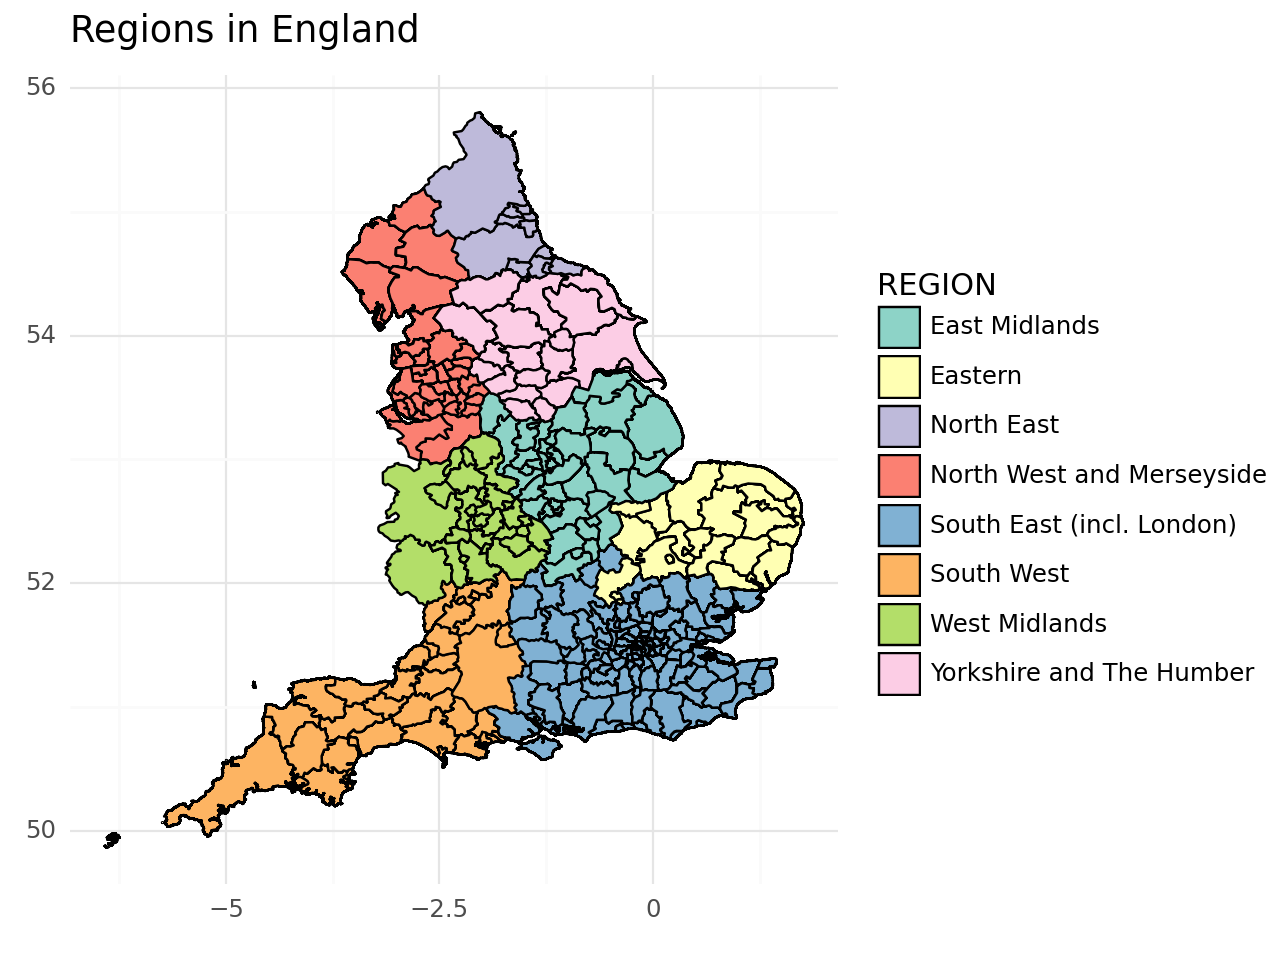

<Figure Size: (640 x 480)>

In [62]:
# Create the ggplot plot
england_regions = (
    ggplot(merged_gdf) +
    geom_map(aes(fill='REGION'), color='black') +
    scale_fill_brewer(type='qual', palette='Set3', name='REGION') +
    theme_minimal() +
    ggtitle('Regions in England')
)

# Display the plot
england_regions

# 3a) Dissolve county lines into regions

In [63]:
# Dissolve the GeoDataFrame on the 'REGION' column
gdf_dissolved = merged_gdf.dissolve(by='REGION', aggfunc='sum')
# Reset the index to make 'REGION' a column again
gdf_dissolved = gdf_dissolved.reset_index()

In [64]:
# preview gdf
gdf_dissolved.head(8)

REGION  \
0              East Midlands   
1                    Eastern   
2                 North East   
3  North West and Merseyside   
4  South East (incl. London)   
5                 South West   
6              West Midlands   
7   Yorkshire and The Humber   

                                            geometry  \
0  MULTIPOLYGON (((-1.60778 52.69389, -1.61086 52...   
1  MULTIPOLYGON (((-0.33528 51.85110, -0.34000 51...   
2  MULTIPOLYGON (((-1.76722 54.51389, -1.77944 54...   
3  MULTIPOLYGON (((-3.11750 53.30347, -3.11750 53...   
4  MULTIPOLYGON (((-1.06972 50.68653, -1.06917 50...   
5  MULTIPOLYGON (((-6.38681 49.86764, -6.38681 49...   
6  POLYGON ((-2.76722 51.87416, -2.77861 51.88583...   
7  MULTIPOLYGON (((-2.00881 53.61752, -2.01694 53...   

                                               GID_0  \
0  GBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRG...   
1  GBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRG...   
2               GBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBR   
3  GBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRG...   
4  GBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRG...   
5  GBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRG...   
6  GBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRG...   
7  GBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRG...   

                                              NAME_0  \
0  United KingdomUnited KingdomUnited KingdomUnit...   
1  United KingdomUnited KingdomUnited KingdomUnit...   
2  United KingdomUnited KingdomUnited KingdomUnit...   
3  United KingdomUnited KingdomUnited KingdomUnit...   
4  United KingdomUnited KingdomUnited KingdomUnit...   
5  United KingdomUnited KingdomUnited KingdomUnit...   
6  United KingdomUnited KingdomUnited KingdomUnit...   
7  United KingdomUnited KingdomUnited KingdomUnit...   

                                               GID_1  \
0  GBR.1_1GBR.1_1GBR.1_1GBR.1_1GBR.1_1GBR.1_1GBR....   
1  GBR.1_1GBR.1_1GBR.1_1GBR.1_1GBR.1_1GBR.1_1GBR....   
2  GBR.1_1GBR.1_1GBR.1_1GBR.1_1GBR.1_1GBR.1_1GBR....   
3  GBR.1_1GBR.1_1GBR.1_1GBR.1_1GBR.1_1GBR.1_1GBR....   
4  GBR.1_1GBR.1_1GBR.1_1GBR.1_1GBR.1_1GBR.1_1GBR....   
5  GBR.1_1GBR.1_1GBR.1_1GBR.1_1GBR.1_1GBR.1_1GBR....   
6  GBR.1_1GBR.1_1GBR.1_1GBR.1_1GBR.1_1GBR.1_1GBR....   
7  GBR.1_1GBR.1_1GBR.1_1GBR.1_1GBR.1_1GBR.1_1GBR....   

                                              NAME_1 NL_NAME_1  \
0  EnglandEnglandEnglandEnglandEnglandEnglandEngl...         0   
1  EnglandEnglandEnglandEnglandEnglandEnglandEngl...         0   
2  EnglandEnglandEnglandEnglandEnglandEnglandEngl...         0   
3  EnglandEnglandEnglandEnglandEnglandEnglandEngl...         0   
4  EnglandEnglandEnglandEnglandEnglandEnglandEngl...         0   
5  EnglandEnglandEnglandEnglandEnglandEnglandEngl...         0   
6  EnglandEnglandEnglandEnglandEnglandEnglandEngl...         0   
7  EnglandEnglandEnglandEnglandEnglandEnglandEngl...         0   

                                               GID_2  \
0  GBR.1.24_1GBR.1.25_1GBR.1.25_1GBR.1.25_1GBR.1....   
1  GBR.1.16_1GBR.1.16_1GBR.1.16_1GBR.1.16_1GBR.1....   
2  GBR.1.23_1GBR.1.30_1GBR.1.34_1GBR.1.39_1GBR.1....   
3  GBR.1.5_1GBR.1.6_1GBR.1.7_1GBR.1.14_1GBR.1.18_...   
4  GBR.1.3_1GBR.1.9_1GBR.1.11_1GBR.1.13_1GBR.1.13...   
5  GBR.1.2_1GBR.1.8_1GBR.1.12_1GBR.1.20_1GBR.1.26...   
6  GBR.1.4_1GBR.1.21_1GBR.1.29_1GBR.1.40_1GBR.1.8...   
7  GBR.1.1_1GBR.1.10_1GBR.1.15_1GBR.1.27_1GBR.1.3...   

                                              NAME_2 NL_NAME_2  \
0  DerbyDerbyshireDerbyshireDerbyshireDerbyshireD...         0   
1  CambridgeshireCambridgeshireCambridgeshireCamb...         0   
2  DarlingtonDurhamGatesheadHartlepoolMiddlesbrou...         0   
3  Blackburn with DarwenBlackpoolBoltonBuryCheshi...         0   
4  BedfordshireBracknell ForestBrighton and HoveB...         0   
5  Bath and North East SomersetBournemouthBristol...         0   
6  BirminghamCoventryDudleyHerefordshireSandwellS...         0   
7  BarnsleyBradfordCalderdaleDoncasterEast Riding...         0   

                  

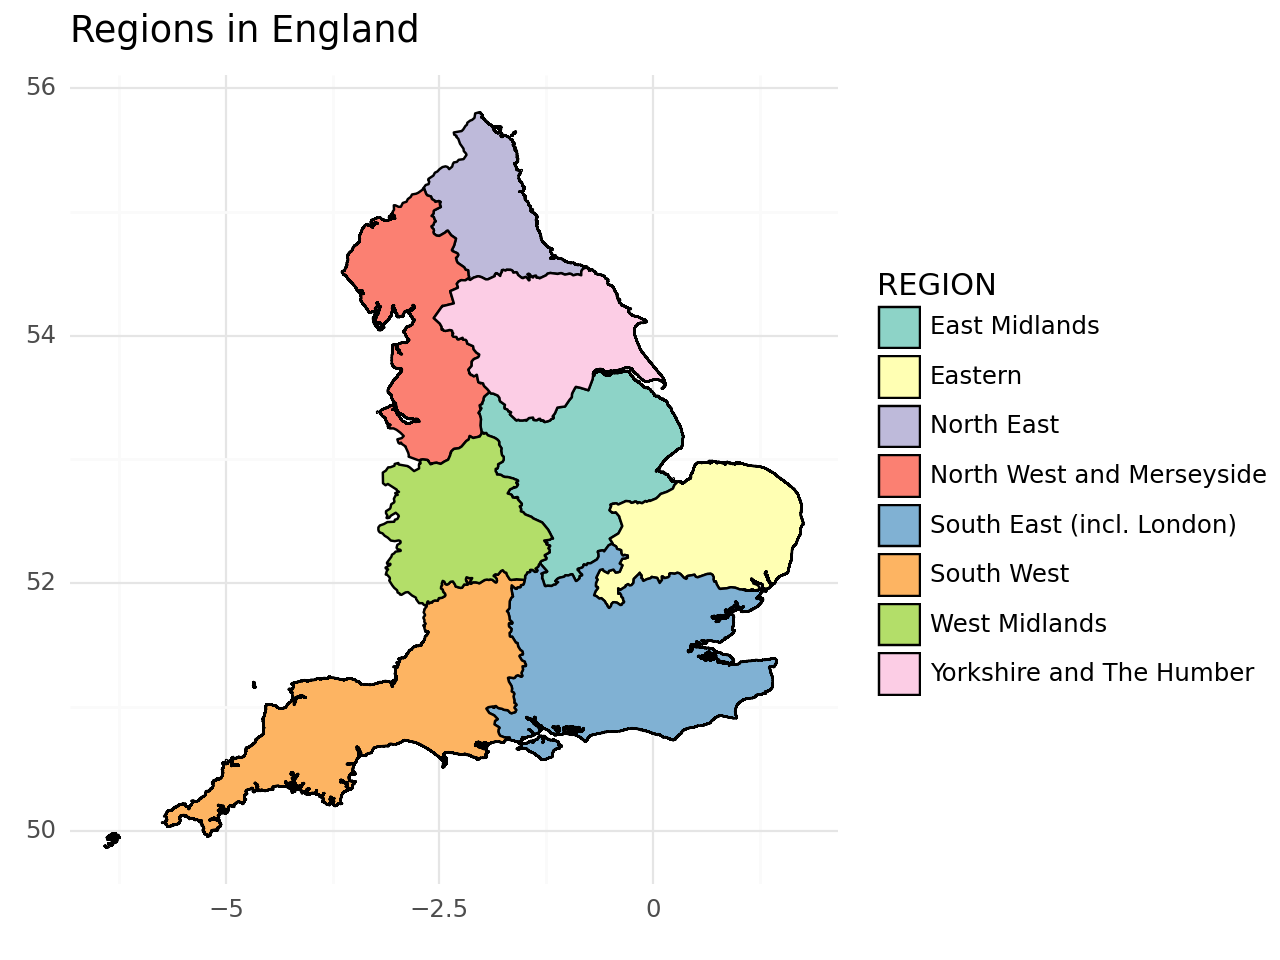

<Figure Size: (640 x 480)>

In [65]:
# Create the ggplot plot
dissolved = (
    ggplot(gdf_dissolved) +
    geom_map(aes(fill='REGION'), color='black') +
    scale_fill_brewer(type='qual', palette='Set3', name='REGION') +
    theme_minimal() +
    ggtitle('Regions in England')
)

# Display the plot
dissolved

# 3b) Import and map agricultural land use per England region.

In [66]:
#Import CSV with county matched to region
csv_file_path = 'https://raw.githubusercontent.com/envirodatascience/final-project-agrivoltaics/main/NUMBER_TRUE_UK_regional_ag_2023%20-%20Total_farmed_area.csv'

# Read the CSV file into a gdf
df_reg_ag = pd.read_csv(csv_file_path)

In [67]:
# Preview file
df_reg_ag.head()

REGION 2010_ha_farmed 2011_ha_farmed 2012_ha_farmed  \
0                 North East        570,420        572,366        575,349   
1  North West and Merseyside        878,791        884,916        878,282   
2   Yorkshire and The Humber      1,066,077      1,073,723      1,086,216   
3              East Midlands      1,176,807      1,185,461      1,197,980   
4              West Midlands        915,412        918,117        929,707   

  2013_ha_farmed 2014_ha_farmed 2015_ha_farmed 2016_ha_farmed 2017_ha_farmed  \
0        588,369        587,576        593,362        603,341        656,386   
1        908,915        903,902        902,711        939,559        984,613   
2      1,091,407      1,087,318      1,086,200      1,114,936      1,160,786   
3      1,181,621      1,193,022      1,187,971      1,203,411      1,190,794   
4        952,969        942,635        931,105        932,382        909,553   

  2018_ha_farmed 2019_ha_farmed 2020(2)_ha_farmed 2021_ha_farmed  \
0        631,312        623,578               NaN        579,749   
1        981,399        972,206               NaN        902,680   
2      1,146,072      1,136,416               NaN      1,098,678   
3      1,191,289      1,192,499               NaN      1,177,690   
4        943,114        943,726               NaN        928,370   

  2022_ha_farmed 2023_ha_farmed  
0        622,123     606,236.80  
1        963,399     941,147.21  
2      1,120,707   1,125,007.54  
3      1,176,757   1,172,079.15  
4        930,637     911,577.27

In [68]:
# Merge the two DataFrames on 'REGION'
gdf_reg_merge = pd.merge(gdf_dissolved, df_reg_ag[['REGION', '2023_ha_farmed']], on='REGION', how='left')

# Display the merged DataFrame
gdf_reg_merge.head(8)

REGION  \
0              East Midlands   
1                    Eastern   
2                 North East   
3  North West and Merseyside   
4  South East (incl. London)   
5                 South West   
6              West Midlands   
7   Yorkshire and The Humber   

                                            geometry  \
0  MULTIPOLYGON (((-1.60778 52.69389, -1.61086 52...   
1  MULTIPOLYGON (((-0.33528 51.85110, -0.34000 51...   
2  MULTIPOLYGON (((-1.76722 54.51389, -1.77944 54...   
3  MULTIPOLYGON (((-3.11750 53.30347, -3.11750 53...   
4  MULTIPOLYGON (((-1.06972 50.68653, -1.06917 50...   
5  MULTIPOLYGON (((-6.38681 49.86764, -6.38681 49...   
6  POLYGON ((-2.76722 51.87416, -2.77861 51.88583...   
7  MULTIPOLYGON (((-2.00881 53.61752, -2.01694 53...   

                                               GID_0  \
0  GBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRG...   
1  GBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRG...   
2               GBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBR   
3  GBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRG...   
4  GBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRG...   
5  GBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRG...   
6  GBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRG...   
7  GBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRGBRG...   

                                              NAME_0  \
0  United KingdomUnited KingdomUnited KingdomUnit...   
1  United KingdomUnited KingdomUnited KingdomUnit...   
2  United KingdomUnited KingdomUnited KingdomUnit...   
3  United KingdomUnited KingdomUnited KingdomUnit...   
4  United KingdomUnited KingdomUnited KingdomUnit...   
5  United KingdomUnited KingdomUnited KingdomUnit...   
6  United KingdomUnited KingdomUnited KingdomUnit...   
7  United KingdomUnited KingdomUnited KingdomUnit...   

                                               GID_1  \
0  GBR.1_1GBR.1_1GBR.1_1GBR.1_1GBR.1_1GBR.1_1GBR....   
1  GBR.1_1GBR.1_1GBR.1_1GBR.1_1GBR.1_1GBR.1_1GBR....   
2  GBR.1_1GBR.1_1GBR.1_1GBR.1_1GBR.1_1GBR.1_1GBR....   
3  GBR.1_1GBR.1_1GBR.1_1GBR.1_1GBR.1_1GBR.1_1GBR....   
4  GBR.1_1GBR.1_1GBR.1_1GBR.1_1GBR.1_1GBR.1_1GBR....   
5  GBR.1_1GBR.1_1GBR.1_1GBR.1_1GBR.1_1GBR.1_1GBR....   
6  GBR.1_1GBR.1_1GBR.1_1GBR.1_1GBR.1_1GBR.1_1GBR....   
7  GBR.1_1GBR.1_1GBR.1_1GBR.1_1GBR.1_1GBR.1_1GBR....   

                                              NAME_1 NL_NAME_1  \
0  EnglandEnglandEnglandEnglandEnglandEnglandEngl...         0   
1  EnglandEnglandEnglandEnglandEnglandEnglandEngl...         0   
2  EnglandEnglandEnglandEnglandEnglandEnglandEngl...         0   
3  EnglandEnglandEnglandEnglandEnglandEnglandEngl...         0   
4  EnglandEnglandEnglandEnglandEnglandEnglandEngl...         0   
5  EnglandEnglandEnglandEnglandEnglandEnglandEngl...         0   
6  EnglandEnglandEnglandEnglandEnglandEnglandEngl...         0   
7  EnglandEnglandEnglandEnglandEnglandEnglandEngl...         0   

                                               GID_2  \
0  GBR.1.24_1GBR.1.25_1GBR.1.25_1GBR.1.25_1GBR.1....   
1  GBR.1.16_1GBR.1.16_1GBR.1.16_1GBR.1.16_1GBR.1....   
2  GBR.1.23_1GBR.1.30_1GBR.1.34_1GBR.1.39_1GBR.1....   
3  GBR.1.5_1GBR.1.6_1GBR.1.7_1GBR.1.14_1GBR.1.18_...   
4  GBR.1.3_1GBR.1.9_1GBR.1.11_1GBR.1.13_1GBR.1.13...   
5  GBR.1.2_1GBR.1.8_1GBR.1.12_1GBR.1.20_1GBR.1.26...   
6  GBR.1.4_1GBR.1.21_1GBR.1.29_1GBR.1.40_1GBR.1.8...   
7  GBR.1.1_1GBR.1.10_1GBR.1.15_1GBR.1.27_1GBR.1.3...   

                                              NAME_2 NL_NAME_2  \
0  DerbyDerbyshireDerbyshireDerbyshireDerbyshireD...         0   
1  CambridgeshireCambridgeshireCambridgeshireCamb...         0   
2  DarlingtonDurhamGatesheadHartlepoolMiddlesbrou...         0   
3  Blackburn with DarwenBlackpoolBoltonBuryCheshi...         0   
4  BedfordshireBracknell ForestBrighton and HoveB...         0   
5  Bath and North East SomersetBournemouthBristol...         0   
6  BirminghamCoventryDudleyHerefordshireSandwellS...         0   
7  BarnsleyBradfordCalderdaleDoncasterEast Riding...         0   

                  

In [69]:
# Check data type
gdf_reg_merge.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   REGION          8 non-null      object  
 1   geometry        8 non-null      geometry
 2   GID_0           8 non-null      object  
 3   NAME_0          8 non-null      object  
 4   GID_1           8 non-null      object  
 5   NAME_1          8 non-null      object  
 6   NL_NAME_1       8 non-null      object  
 7   GID_2           8 non-null      object  
 8   NAME_2          8 non-null      object  
 9   NL_NAME_2       8 non-null      object  
 10  GID_3           8 non-null      object  
 11  NAME_3          8 non-null      object  
 12  VARNAME_3       8 non-null      object  
 13  NL_NAME_3       8 non-null      object  
 14  TYPE_3          8 non-null      object  
 15  ENGTYPE_3       8 non-null      object  
 16  CC_3            8 non-null      object  
 17  HASC_3      

In [70]:
gdf_reg_merge['2023_ha_farmed'] = gdf_reg_merge['2023_ha_farmed'].str.replace(",", "").astype(float)

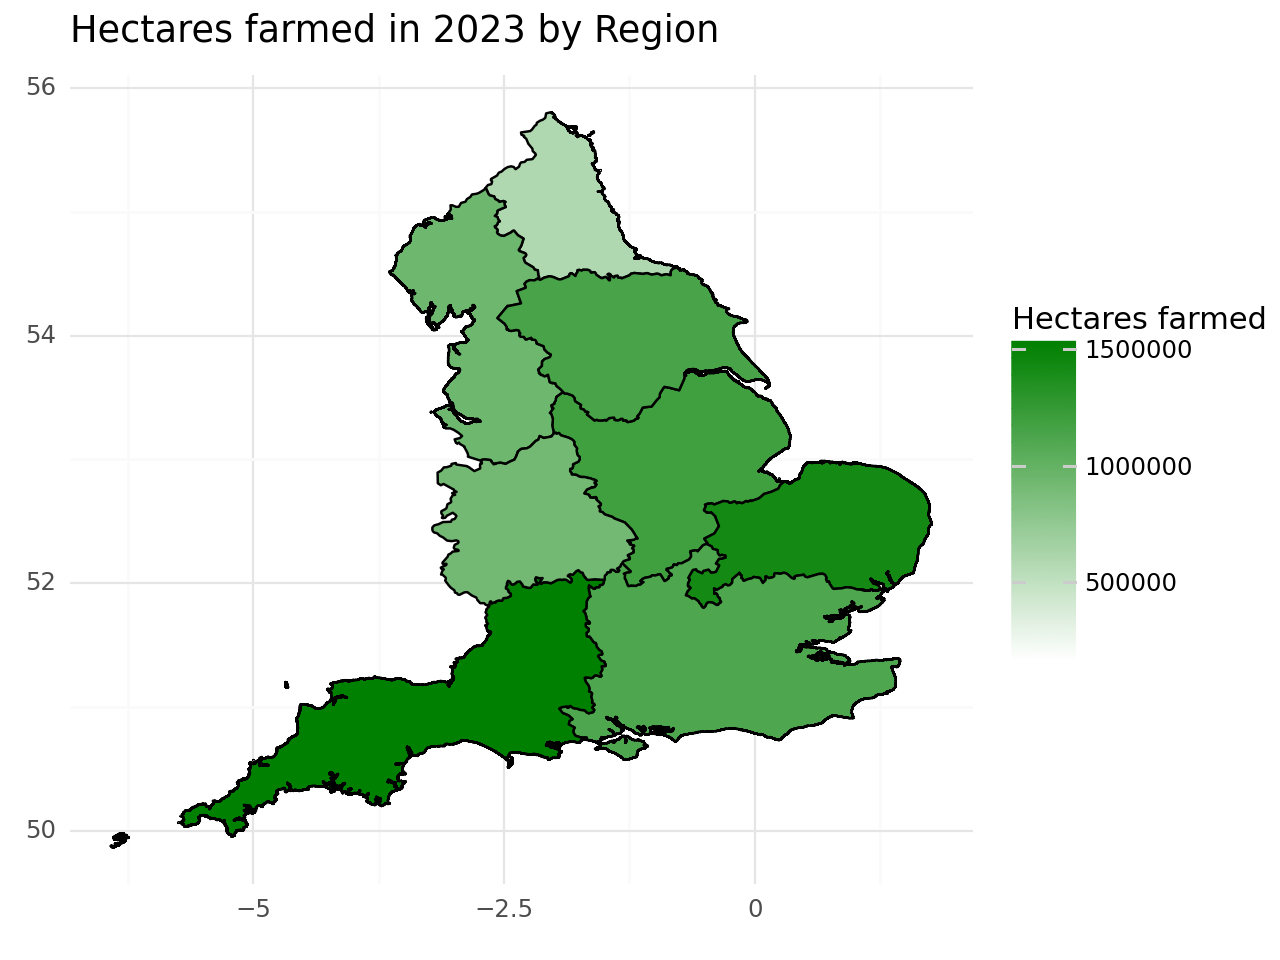

<Figure Size: (640 x 480)>

In [72]:
# Create a heatmap
heatmap = (
    ggplot(gdf_reg_merge) +
    geom_map(aes(fill='2023_ha_farmed'), color='black') +
    scale_fill_gradient(low='white', high='green', limits=[1500000,200000]) +
    theme_minimal() +
    ggtitle('Hectares farmed in 2023 by Region') +
    labs(fill='Hectares farmed')
)

heatmap

From this heatmap, we can see that the South West and Eastern regions have the most hectares of agricultural land farmed in 2023.

# 4) Analytics

There are many factors - commercial, industrial, physical, and social - that influence what would make a successful agrivoltaics site. However, considering where existing solar farms are now gives us an idea of what sites are already considered commercially viable, considering where the greatest amount of sunlight is gives us an idea of where such an infrastructure project could maximize its energy output, and considering where the most agricultural land use is suggests areas with the land use and industry to make agrivoltaics possible.

We can create a scatterplot that combines these factors to make an initial recommendation for the region in England that it would make sense to scope a pilot agrivoltaics program in.

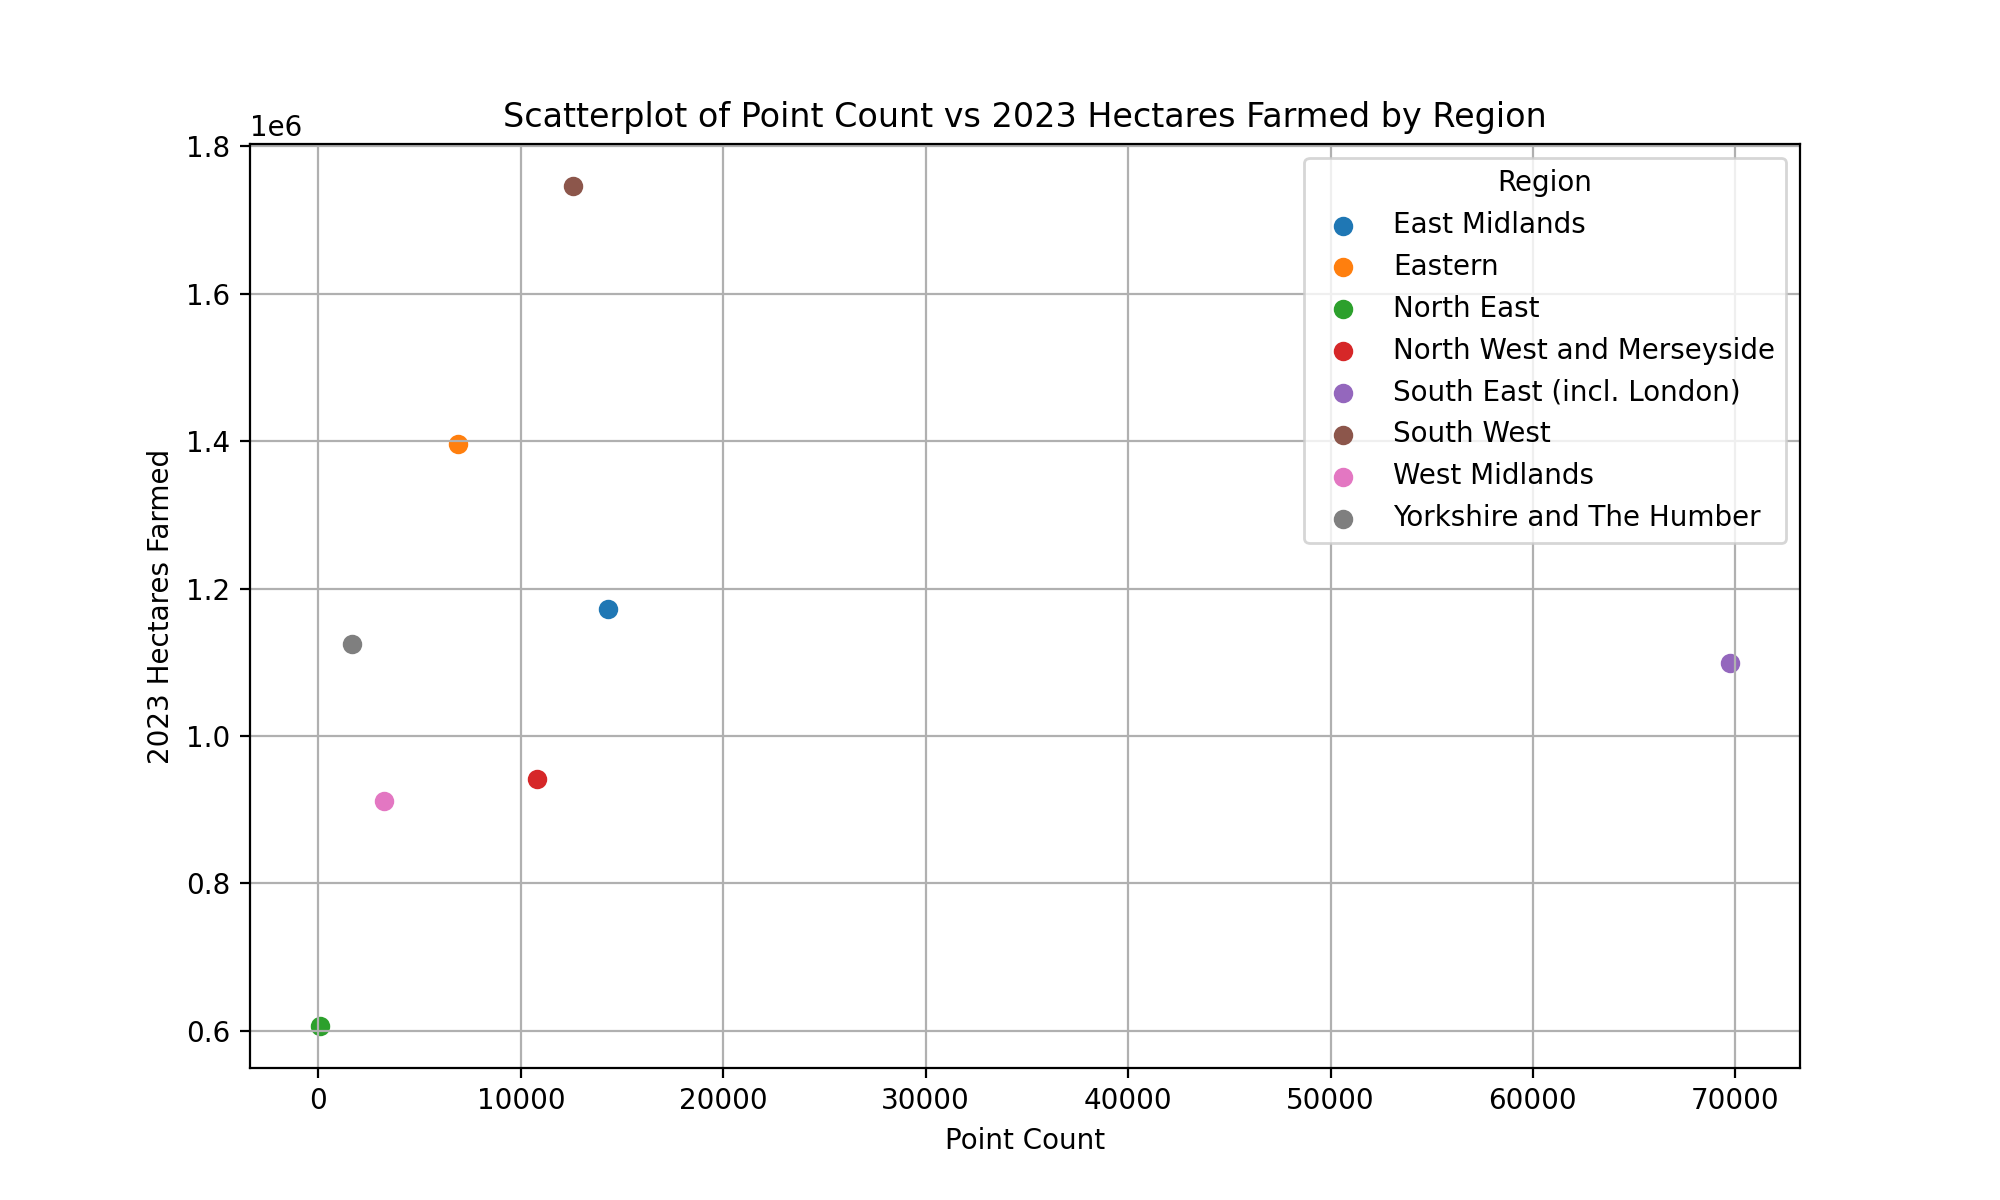

In [73]:
# Create a scatterplot
plt.figure(figsize=(10, 6))
for region, region_data in gdf_reg_merge.groupby('REGION'):
    plt.scatter(region_data['point_count'], region_data['2023_ha_farmed'], label=region)

# Set labels and title
plt.xlabel('Point Count')
plt.ylabel('2023 Hectares Farmed')
plt.title('Scatterplot of Point Count vs 2023 Hectares Farmed by Region')

# Add legend
plt.legend(title='Region', loc='upper right')

# Show plot
plt.grid(True)
plt.show()

From this scatter plot, we can see that the South East (including London) region has by far the most solar farms, but not the greatest agricultural land. This makes sense as the region is largely composed of London and its outskirts, an urban setting that holds many urban solar operations but does not have as great a rural setting for agricultural land use.

By setting the limits of the scatterplot to exclude the South East inc. London region, we can get a greater sense of which of the other regions may be most suitable.

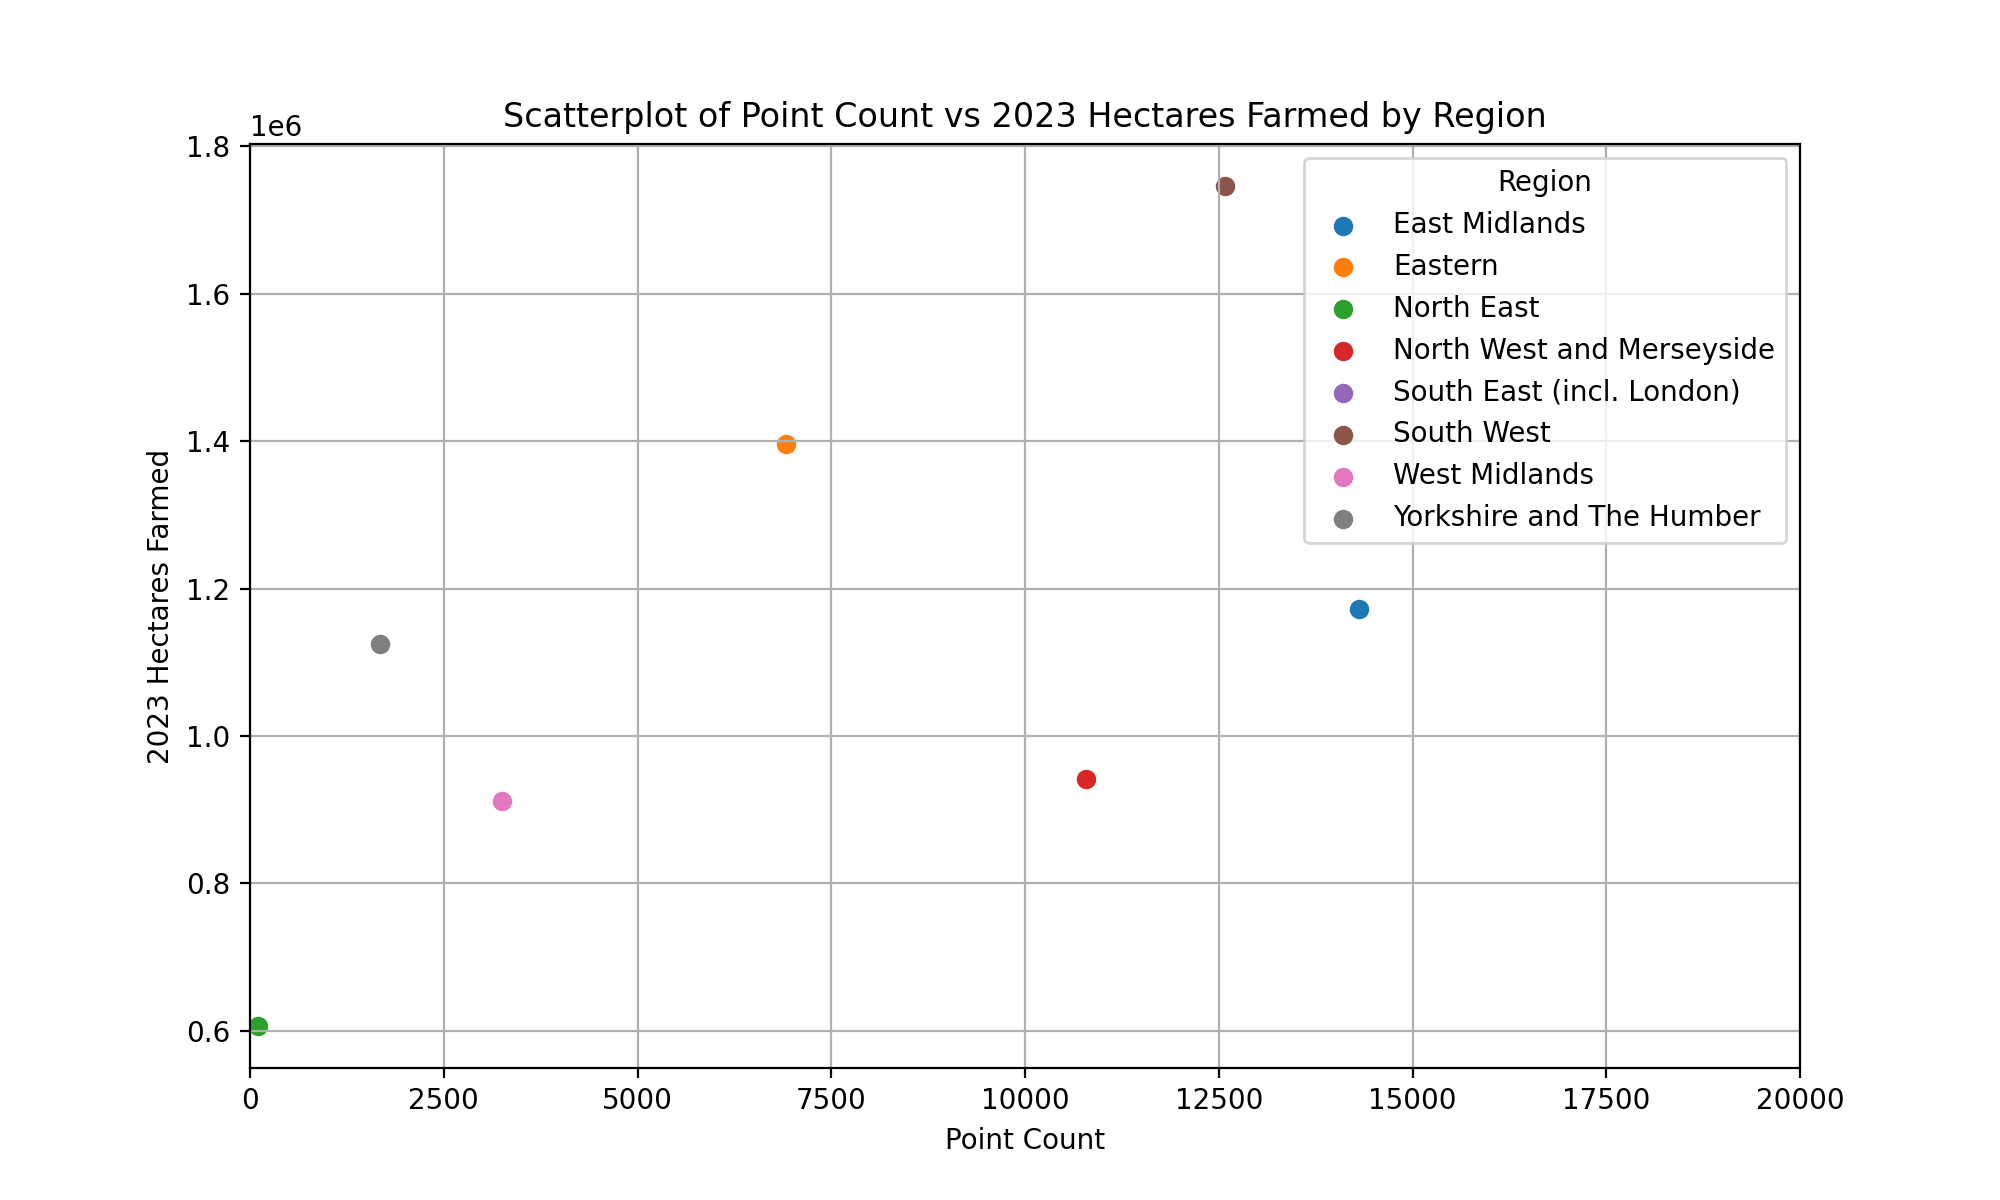

In [74]:
# Create a scatterplot
plt.figure(figsize=(10, 6))
for region, region_data in gdf_reg_merge.groupby('REGION'):
    plt.scatter(region_data['point_count'], region_data['2023_ha_farmed'], label=region)

# Set labels and title
plt.xlabel('Point Count')
plt.ylabel('2023 Hectares Farmed')
plt.title('Scatterplot of Point Count vs 2023 Hectares Farmed by Region')

# Set range for x-axis (point_count) to 20,000
plt.xlim(0, 20000)

# Add legend
plt.legend(title='Region', loc='upper right')

# Show plot
plt.grid(True)
plt.show()

With these scale limits applied, we can more clearly see that the South West and the East Midlands have the most solar farms, while the South West has the most agricultural land use. The South West is also the south-most region and so recieves the most solar hours even during the shortest days of the year. As such, we would recommend to the UK government that they further investigate the South West region of England to further develop a agrivoltaics pilot project.